In [1]:
!pip install jiwer torch torchcodec aiohttp smart_open soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 111.6 MB/s eta 0:00:00


In [2]:
!pip -q install -U "datasets>=3.0.2" "huggingface_hub>=0.24.0" "fsspec[http]==2025.3.0" "transformers==4.55.4" "peft==0.17.1" "accelerate >=1.3.0"  "evaluate==0.4.2" "pyarrow<20.0.0a0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.8 MB/s eta 0:00:00


In [ ]:
# OPTIONAL: only if using 8-bit or 4-bit quantization
# Uninstall and reinstall bitsandbytes and triton to ensure latest compatible versions
!pip uninstall -y bitsandbytes triton
!pip install -q -U bitsandbytes triton

Found existing installation: triton 3.4.0
Uninstalling triton-3.4.0:
  Successfully uninstalled triton-3.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 MB 7.2 MB/s eta 0:00:00


In [3]:
# Core libraries
import random, numpy as np, torch

# Hugging Face libraries for dataset loading, Model loading,inferenicng, evalaution and Fine tuning
from datasets import Dataset, load_dataset, Audio
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
import evaluate

# Audio processing libraries
import soundfile as sf
import torchaudio
# Utility libraries
from dataclasses import dataclass, replace
from typing import List, Dict, Any
import os
import re
from jiwer import wer, cer
import io, tempfile, uuid
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json, time, hashlib, csv

In [4]:
# ======================================================================
#  Hugging Face Login is required for gated Datasets
# ======================================================================
from huggingface_hub import login
from google.colab import userdata

token = userdata.get('HF_TOKEN')  # This is stored as Colab Secret named HF_TOKEN
if token:
    login(token)
else:
    print("HF_TOKEN not set; proceeding unauthenticated (ok for non gated and public datasets).")

---------------------------------------------------------------------------------------------------------



| Language             | Continent              | Resource Level (in Whisper pre-training) | Finance Relevance                                                                 |
| -------------------- | ---------------------- | ---------------------------------------- | --------------------------------------------------------------------------------- |
| **English (en-US)**  | North America / Europe | **High**                                 | Global financial lingua franca — earnings calls, filings, and analyst briefings.  |
| **Spanish (es-419)** | Latin America / Europe | **High**                                 | Key for LATAM finance and banking communications.                                 |
| **German (de-DE)**   | Europe                 | **High**                                 | Used in EU and DAX corporate reporting.                                           |
| **Arabic (ar-EG)**   | Middle East / Africa   | **Mid**                                  | Central to Gulf and North African finance and energy sectors.                     |
| **Urdu (ur-PK)**     | South Asia             | **Mid**                                  | Important for micro-finance and banking in Pakistan.                              |
| **Hindi (hi-IN)**    | South Asia             | **Low**                                  | Critical for Indian retail investor communication and government finance schemes. |
| **Yoruba (yo-NG)**   | West Africa            | **Low**                                  | Nigeria’s fintech and banking markets require local language ASR capabilities.    |
| **Amharic (am-ET)**  | East Africa            | **Low**                                  | Ethiopia’s rapidly growing finance sector needs inclusive digital access.         |



In [5]:
# === Experiment Config ===
@dataclass
class LangSpec:
    code: str           # e.g., "hi-IN"
    family: str         # e.g., "Indic", "Afro-Asiatic", "Sino-Tibetan"
    resource_level: str # "low" | "mid" | "high"
    datasets: List[str] # ["common_voice", "fleurs"]

LANGS: List[LangSpec] = [
    # Low-resource (Indic + African)
    LangSpec("hi-IN", "Indic", "low", ["common_voice", "fleurs"]),       # Hindi

    LangSpec("am-ET", "Afro-Asiatic", "low", ["fleurs"]),                # Amharic
    LangSpec("yo-NG", "Niger-Congo", "low", ["fleurs"]),                 # Yoruba

    # Mid-resource
    LangSpec("ar-EG", "Afro-Asiatic", "mid", ["common_voice", "fleurs"]), # Arabic (Saudi/Modern Standard)
    LangSpec("ur-PK", "Indic", "mid", ["common_voice", "fleurs"]),       # Urdu


    # High-resource
    LangSpec("en-US", "Indo-European", "high",  ["fleurs"]),                # English
    LangSpec("es-419", "Indo-European", "high", ["fleurs"]),                # Spanish
    LangSpec("de-de", "Indo-European", "high",   ["fleurs"]),               # German
]


MODELS = [
    "openai/whisper-tiny",
    "openai/whisper-base",
    "openai/whisper-small",
]

DECODE = dict(beam_size=5, best_of=5, temperature=0.0)
SAMPLE_HOURS = dict(train=1.0, dev=0.0001, test=0.1)   # Default 'train' key with 1 hour
SEED = 42

# Dataset Readers

In [6]:
# --- Minimal mappers ---
def cv17_lang_config(bcp47: str) -> str:
    return "zh-CN" if bcp47.lower()=="zh-cn" else bcp47.split("-")[0].lower()

def fleurs_lang_config(bcp47: str) -> str:
    parts = bcp47.split("-")
    return f"{parts[0].lower()}_{parts[1].lower()}" if len(parts)==2 else f"{parts[0].lower()}_{parts[0].lower()}"

# --- Split names on Parquet trees (both use train/validation/test) ---
def parquet_split_name(split: str) -> str:
    s = split.lower()
    return {"dev": "validation", "val": "validation"}.get(s, s)



In [31]:
# === Loading datasets ===

def load_manifest(lang_code: str, dataset: str, split: str, max_items: int =2000):
    items = []
    # Get the standard split name (validation or test)
    sp = parquet_split_name(split)

    if dataset == "common_voice":
        cfg  = cv17_lang_config(lang_code)

        base = f"https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0/resolve/refs/convert/parquet/{cfg}/"
        # Use sp_mapped for the data_files key, and sp for accessing the loaded dataset
        ds = load_dataset("parquet", data_files={sp: base + f"{sp}/0000.parquet"})[sp]
        # Ensure max_items does not exceed dataset size
        if max_items is not None and max_items < len(ds):
          ds = ds.select(range(max_items))

        ds = ds.cast_column("audio", Audio(sampling_rate=16_000, decode=False))
        print("dataset columns:", ds.column_names)

        for ex in ds:
            a = ex.get("audio")
            text = ex.get("sentence") or ex.get("text") or ""
            if not text:
                continue

            # Calculate duration for Common Voice
            duration_s = 0.0
            apath = ex.get("path")
            if isinstance(apath, str) and len(apath) > 0 and os.path.exists(apath):
                try:
                    metadata = torchaudio.info(apath)
                    duration_s = metadata.num_frames / metadata.sample_rate
                except Exception as e:
                    print(f"Could not get audio info for {apath}: {e}")

            item = {"audio": a, "duration_s": duration_s, "text": text}
            # if there is a local file, include it too (optional)
            if isinstance(apath, str) and os.path.exists(apath):
                item["audio_path"] = apath
            items.append(item)
        return items

    elif dataset == "fleurs":
        cfg  = fleurs_lang_config(lang_code)
        base = f"https://huggingface.co/datasets/google/fleurs/resolve/refs/convert/parquet/{cfg}/"
        ds = load_dataset("parquet", data_files={sp: base + f"{sp}/0000.parquet"})[sp]
        # Ensure max_items does not exceed dataset size
        if max_items is not None and max_items < len(ds):
          ds = ds.select(range(max_items))

        ds = ds.cast_column("audio", Audio(sampling_rate=16_000, decode=False))
        print("dataset columns:", ds.column_names)

        for ex in ds:
            a = ex.get("audio")
            text = ex.get("transcription") or ex.get("raw_transcription") or ex.get("text") or ""
            if not text:
                continue

            # Calculate duration for Fleurs
            duration_s = 0.0
            apath = ex.get("path")
            if isinstance(apath, str) and len(apath) > 0 and os.path.exists(apath):
                try:
                    metadata = torchaudio.info(apath)
                    duration_s = metadata.num_frames / metadata.sample_rate
                except Exception as e:
                    print(f"Could not get audio info for {apath}: {e}")

            item = {"audio": a, "duration_s": duration_s, "text": text}
            if isinstance(apath, str) and os.path.exists(apath):
                item["audio_path"] = apath
            items.append(item)
        return items

    else:
        raise ValueError(f"Unknown dataset: {dataset}")

In [ ]:
# Test load_manifest
test_lang_code = "hi-IN"
test_dataset = "fleurs"
test_split = "test"
test_max_items =2       # Load a small number of items for testing

print(f"Loading manifest for {test_lang_code} from {test_dataset} ({test_split} split)...")
test_manifest_items = load_manifest(test_lang_code, test_dataset, test_split, max_items=test_max_items)

print(f"\nLoaded {len(test_manifest_items)} items. Printing details:")
for i, item in enumerate(test_manifest_items):
    print(f"Item {i+1}:")
    print(f"  Text: {item.get('text', 'N/A')}")

if not test_manifest_items:
    print("No items were loaded. Please check the language code, dataset, and split.")

Loading manifest for hi-IN from fleurs (test split)...


hi_in/test/0000.parquet:   0%|          | 0.00/306M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']

Loaded 2 items. Printing details:
Item 1:
  Text: कुछ अणुओं में अस्थिर केंद्रक होता है जिसका मतलब यह है कि उनमें थोड़े या बिना किसी झटके से टूटने की प्रवृत्ति होती है
Item 2:
  Text: ग्रीनलैंड को बहुत कम जगह बसाया गया था नॉर्स सगास में वे कहते हैं कि एरिक रेड हत्या के लिए आइसलैंड से निर्वासित किया गया था और आगे पश्चिम की यात्रा करते समय ग्रीनलैंड मिला जिसे ग्रीनलैंड नाम दिया गया


In [9]:
# ======================================================================
# Uniform Data Sampling Utilities
# - Build capped validation/test sets by total hours to compare fairly across languages.
# ======================================================================

def cap_by_hours(items: List[Dict], hours: float) -> List[Dict]:
    target = hours * 3600.0
    out, acc = [], 0.0
    # Sort shortest-first so we pack more diverse utterances under the cap
    for it in sorted(items, key=lambda x: x.get("duration_s", 0.0)):
        dur = it.get("duration_s", 0.0)
        if acc + dur > target:
            break
        out.append(it)
        acc += dur
    return out

def build_split(lang: LangSpec, split: str, max_hours: float = None, max_items: int = None):
    all_items = []
    for ds in lang.datasets:
        all_items += load_manifest(lang.code, ds, split)

    # Apply both caps and take the minimum
    capped_items = all_items
    if max_hours is not None:
        capped_items = cap_by_hours(capped_items, max_hours)
    if max_items is not None and max_items < len(capped_items):
        capped_items = capped_items[:max_items]

    random.shuffle(capped_items)
    return capped_items

# DATASET Preprocessor utility functions

In [10]:
# === Data Normalization & Metrics ===

def normalize(text: str) -> str:
    t = (text or "").lower().strip()
    t = re.sub(r"[^\w\s]", "", t)  # remove punctuation
    t = re.sub(r"\s+", " ", t)
    return t

def compute_metrics(refs, hyps):
    refs_n = [normalize(r) for r in refs]
    hyps_n = [normalize(h) for h in hyps]
    return dict(WER=wer(refs_n, hyps_n), CER=cer(refs_n, hyps_n))

In [12]:
# === Data Preprocessing ===
# Map BCP-47 -> whisper's language tag
def _whisper_lang(lang_code: str) -> str:
    lc = (lang_code or "").lower()
    if lc == "zh-cn":  # whisper expects 'chinese' as 'zh' token;
        return "zh"
    return lc.split("-")[0] if "-" in lc else lc

def _ensure_waveform_16k(item) -> torch.Tensor:
    """
    Returns a mono 16 kHz torch tensor in range [-1, 1].
    Prioritizes audio data from item['audio'] (array or bytes),
    falls back to item['audio_path'] only if audio data is not present
    and the path is local.
    """
    a = item.get("audio") or {}
    arr = a.get("array")
    sr = a.get("sampling_rate")
    audio_bytes = a.get("bytes")
    apath = item.get("audio_path")

    waveform = None

    # (1) Decoded array and sampling rate from dict
    if arr is not None and sr is not None:
        sr = int(sr)
        waveform = torch.from_numpy(arr).float()
        if waveform.ndim == 1:
            waveform = waveform.unsqueeze(0)
        elif waveform.ndim == 2 and waveform.shape[0] > 1:
            # stereo -> mono
            waveform = waveform.mean(dim=0, keepdim=True)

    # (2) Raw bytes -> decode
    elif audio_bytes:
        with sf.SoundFile(io.BytesIO(audio_bytes)) as src:
            data = src.read(always_2d=True, dtype="float32")
            sr = src.samplerate
        waveform = torch.from_numpy(data.T)  # (channels, samples)

    # (3) File path case (only if it looks like a local path and no other audio data)
    elif isinstance(apath, str) and len(apath) > 0 and os.path.exists(apath):
         waveform, sr = torchaudio.load(apath)

    if waveform is None or sr is None:
        raise ValueError("No usable audio data (array, bytes, or accessible local path) found in item")

    # resample if needed
    if sr != 16000:
        waveform = torchaudio.functional.resample(waveform, sr, 16000)

    # ensure mono
    if waveform.ndim == 2 and waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    elif waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)

    return waveform.squeeze(0)  # shape: (samples,)

# Inferencing utilities

In [13]:
# === Batch Inference ===

def transcribe_batch(model_id: str, items, lang_code: str):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id).to(device)
    model.eval()

    # pull decode params with safe defaults
    beam_size   = (globals().get("DECODE", {}) or {}).get("beam_size", 5)
    temperature = (globals().get("DECODE", {}) or {}).get("temperature", 0.0)

    # Set task & language on generation config
    lang_tag = _whisper_lang(lang_code)
    gen_cfg = model.generation_config
    gen_cfg.task = "transcribe"
    gen_cfg.language = lang_tag
    gen_cfg.num_beams = beam_size
    gen_cfg.use_cache = False # Disable caching
    model.generation_config = gen_cfg


    hyps, refs = [], []

    with torch.no_grad():
        for it in items:
            # ---- get mono 16k waveform ----
            wav = _ensure_waveform_16k(it)  # returns 1D torch.Tensor @16k

            # Get attention_mask and pass it through
            inputs = processor(
                wav,
                sampling_rate=16000,
                return_tensors="pt",
                return_attention_mask=True,
            )
            input_features = inputs["input_features"].to(device)
            attention_mask = inputs.get("attention_mask")
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)

            # Use generation_config set earlier; and provide features (+ mask)
            generated = model.generate(
                input_features=input_features,
                attention_mask=attention_mask,
            )

            text = processor.batch_decode(generated, skip_special_tokens=True)[0]
            hyps.append(text)
            refs.append(it.get("text", ""))

    return refs, hyps

# Testing Out the pipeline before Evaluation

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

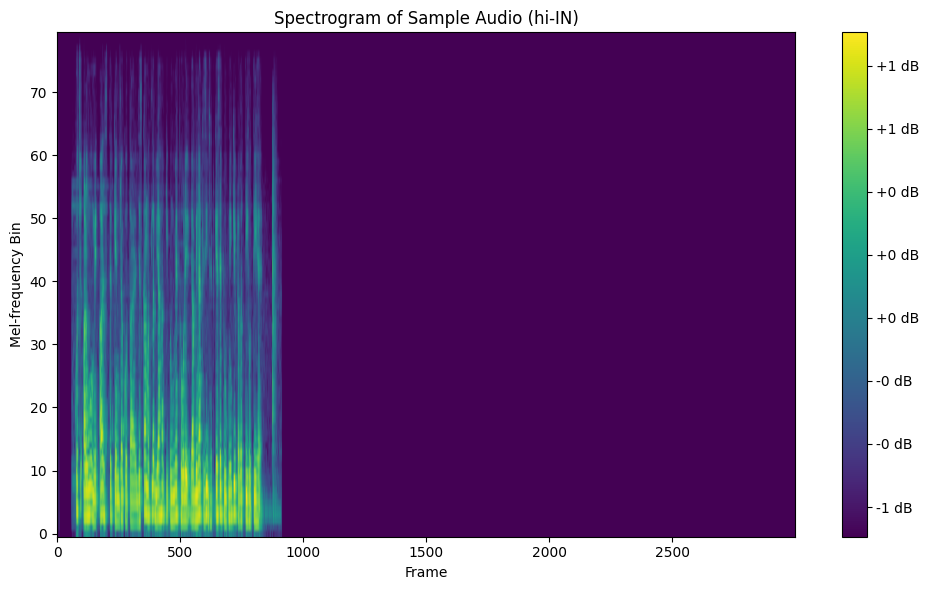

Original Text: कुछ अणुओं में अस्थिर केंद्रक होता है जिसका मतलब यह है कि उनमें थोड़े या बिना किसी झटके से टूटने की प्रवृत्ति होती है


In [ ]:

# Select a language (e.g., Hindi) and a model for the processor
test_lang = next(l for l in LANGS if l.code == "hi-IN")
test_model_id = "openai/whisper-tiny" # Using a small model for processor

# Load a small sample from the test split
test_items = build_split(test_lang, "test",max_hours=0.001, max_items=3)

if len(test_items) > 0:
    audio_item = test_items[1]

    # Ensure audio is 16kHz mono
    waveform = _ensure_waveform_16k(audio_item)
    sampling_rate = 16000

    # Load the processor to get the feature extractor
    processor = AutoProcessor.from_pretrained(test_model_id)

    # Extract features (spectrogram)
    input_features = processor.feature_extractor(waveform.numpy(), sampling_rate=sampling_rate).input_features[0]

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(input_features, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Spectrogram of Sample Audio ({test_lang.code})")
    plt.xlabel("Frame")
    plt.ylabel("Mel-frequency Bin")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

    print(f"Original Text: {audio_item.get('text', 'N/A')}")

else:
    print(f"No test items found for language {test_lang.code} with max_items=3.")

# Model Evaluation Utility

In [14]:
# === Evaluation Driver ===
def eval_language(model_id: str, lang) -> dict:
    test = build_split(lang, "test", SAMPLE_HOURS["test"])
    if len(test) == 0:
        return dict(model=model_id, lang=lang.code, family=lang.family, level=lang.resource_level, WER=None, CER=None)
    refs, hyps = transcribe_batch(model_id, test, lang.code)
    m = compute_metrics(refs, hyps)
    return dict(model=model_id, lang=lang.code, family=lang.family, level=lang.resource_level, **m)

In [ ]:
#Eval Run
rows = []
for m in MODELS:
    for lang in LANGS:
        rows.append(eval_language(m, lang))
df_eval = pd.DataFrame(rows).sort_values(["level","family","lang","model"])
# Display only the head
display(df_eval.head())

hi_in/test/0000.parquet:   0%|          | 0.00/306M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

am_et/test/0000.parquet:   0%|          | 0.00/369M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


yo_ng/test/0000.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


ar_eg/test/0000.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


ur_pk/test/0000.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


en_us/test/0000.parquet:   0%|          | 0.00/402M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


es_419/test/0000.parquet:   0%|          | 0.00/543M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


de_de/test/0000.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_gro

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_gro

,model,lang,family,level,WER,CER
15,openai/whisper-base,de-de,Indo-European,high,0.164116,0.057583
23,openai/whisper-small,de-de,Indo-European,high,0.092687,0.036740
7,openai/whisper-tiny,de-de,Indo-European,high,0.257653,0.090568
13,openai/whisper-base,en-US,Indo-European,high,0.089109,0.057764
21,openai/whisper-small,en-US,Indo-European,high,0.064592,0.028882


In [ ]:
df_eval


,model,lang,family,level,WER,CER
15,openai/whisper-base,de-de,Indo-European,high,0.164116,0.057583
23,openai/whisper-small,de-de,Indo-European,high,0.092687,0.036740
7,openai/whisper-tiny,de-de,Indo-European,high,0.257653,0.090568
13,openai/whisper-base,en-US,Indo-European,high,0.089109,0.057764
21,openai/whisper-small,en-US,Indo-European,high,0.064592,0.028882
5,openai/whisper-tiny,en-US,Indo-European,high,0.111740,0.049651
14,openai/whisper-base,es-419,Indo-European,high,0.099722,0.033863
22,openai/whisper-small,es-419,Indo-European,high,0.056019,0.017823
6,openai/whisper-tiny,es-419,Indo-European,high,0.159317,0.049835
9,openai/whisper-base,am-ET,Afro-Asiatic,low,1.391487,1.801715


# Plotting The Results

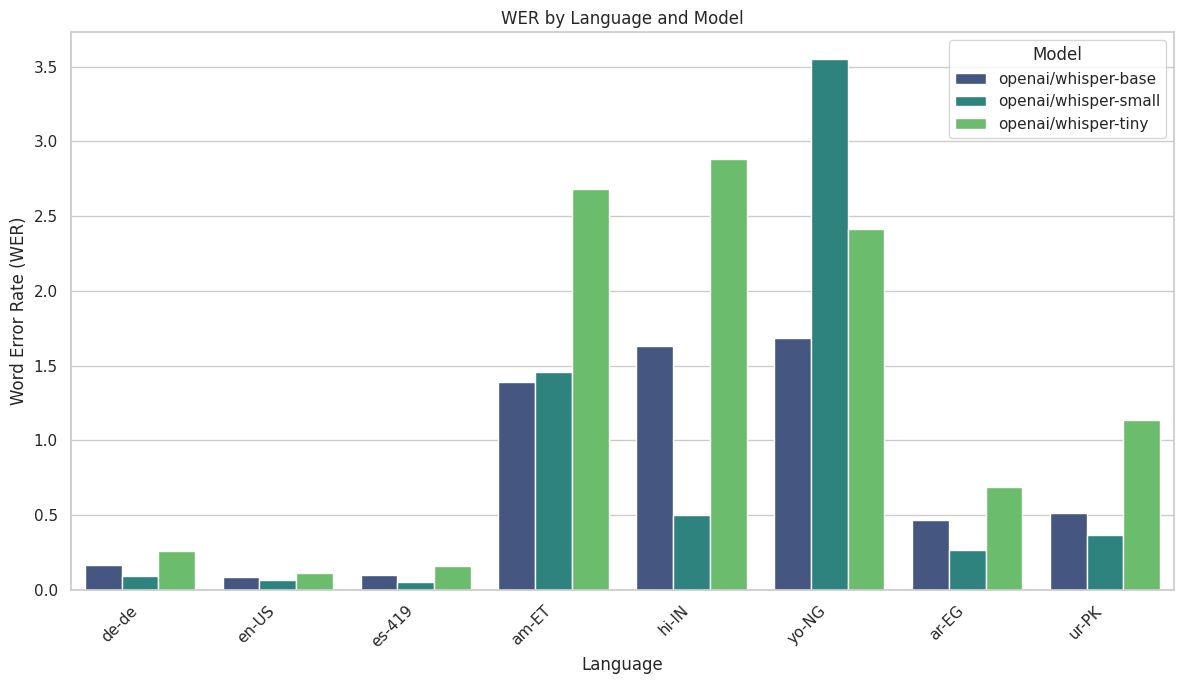

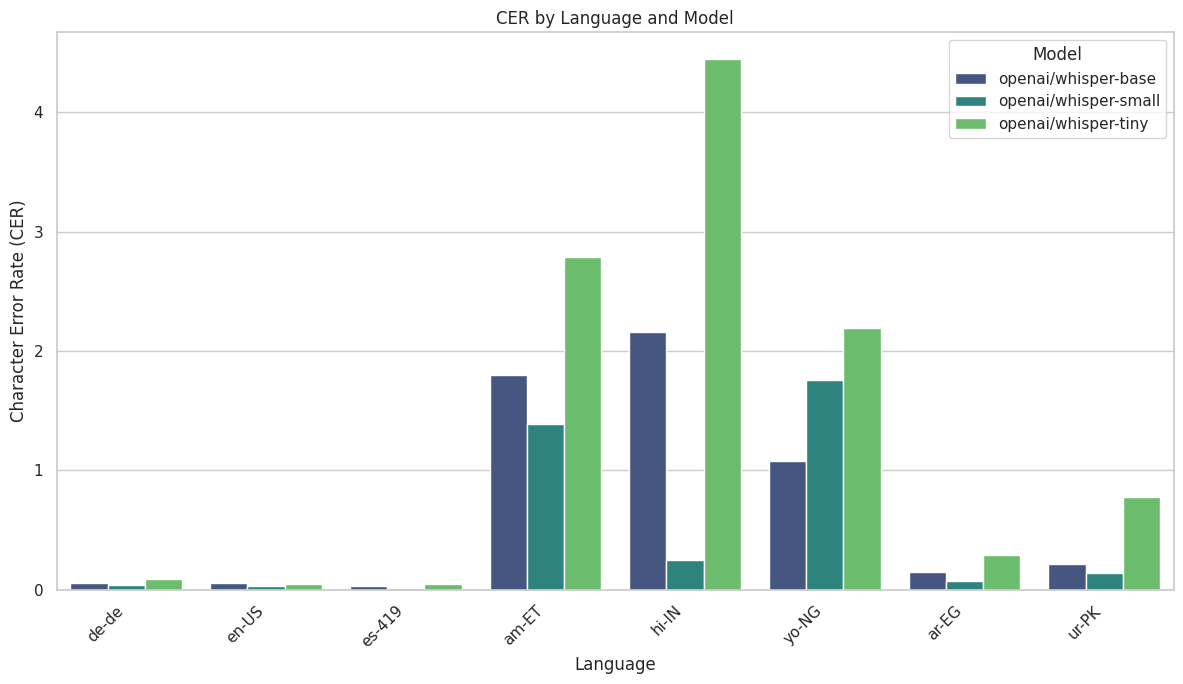

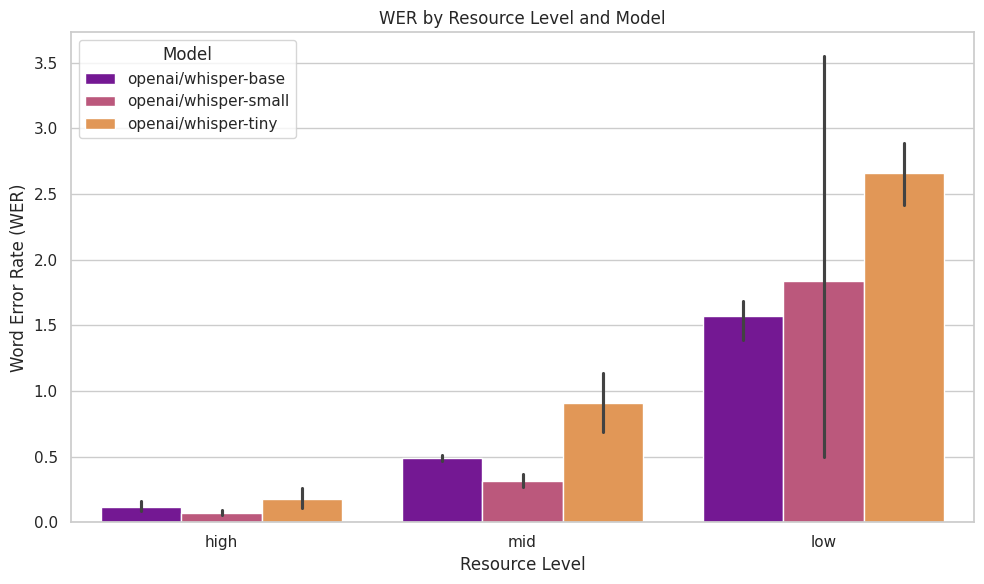

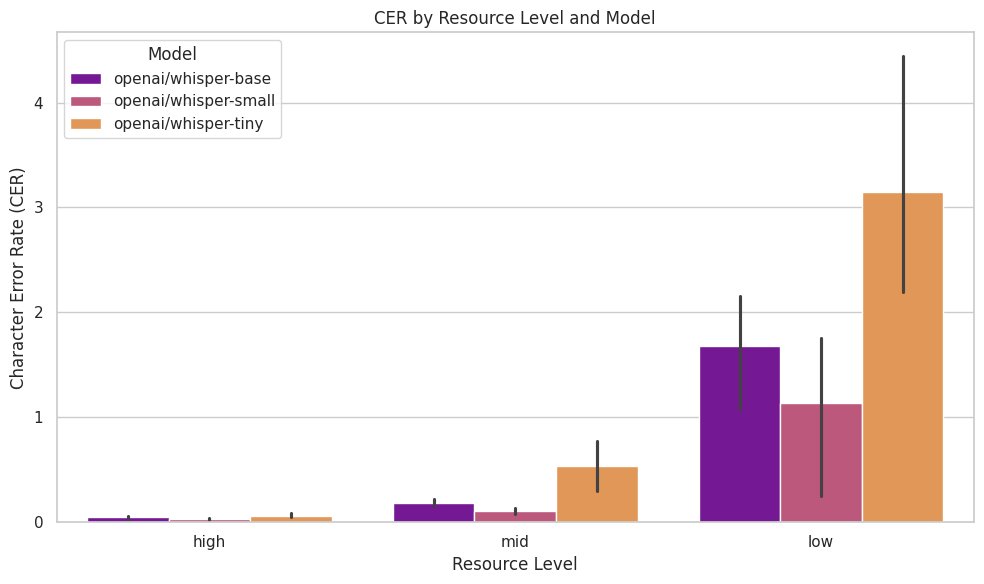

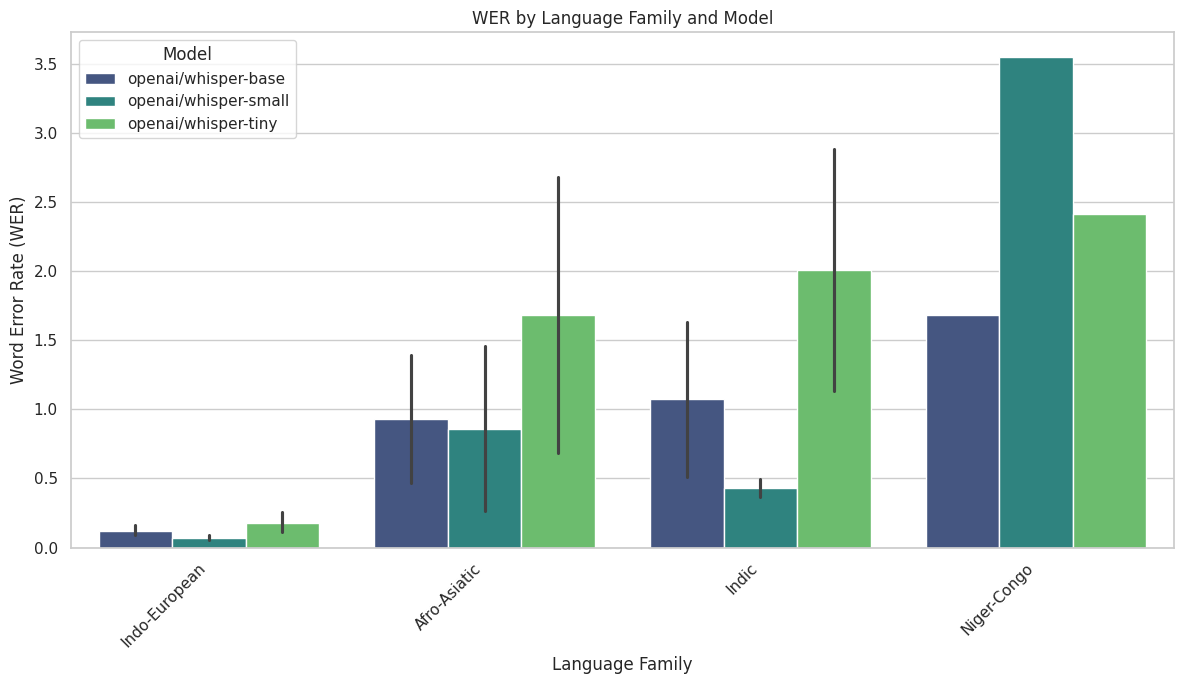

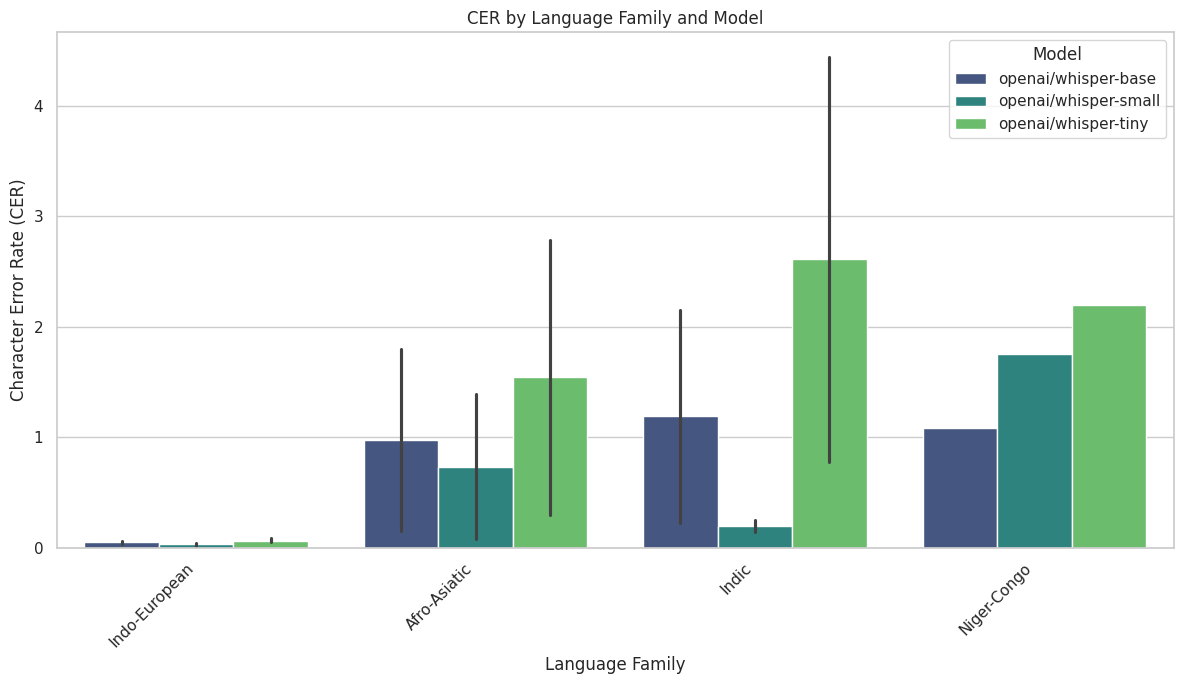

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Sort for better visualization
df_eval_sorted = df_eval.sort_values(["level", "family", "lang", "model"])

# Plotting WER by Language and Model
plt.figure(figsize=(12, 7))
sns.barplot(data=df_eval_sorted, x="lang", y="WER", hue="model", palette="viridis")
plt.title("WER by Language and Model")
plt.ylabel("Word Error Rate (WER)")
plt.xlabel("Language")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plotting CER by Language and Model
plt.figure(figsize=(12, 7))
sns.barplot(data=df_eval_sorted, x="lang", y="CER", hue="model", palette="viridis")
plt.title("CER by Language and Model")
plt.ylabel("Character Error Rate (CER)")
plt.xlabel("Language")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plotting WER by Resource Level and Model
plt.figure(figsize=(10, 6))
sns.barplot(data=df_eval_sorted, x="level", y="WER", hue="model", palette="plasma", order=["high", "mid", "low"])
plt.title("WER by Resource Level and Model")
plt.ylabel("Word Error Rate (WER)")
plt.xlabel("Resource Level")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plotting CER by Resource Level and Model
plt.figure(figsize=(10, 6))
sns.barplot(data=df_eval_sorted, x="level", y="CER", hue="model", palette="plasma", order=["high", "mid", "low"])
plt.title("CER by Resource Level and Model")
plt.ylabel("Character Error Rate (CER)")
plt.xlabel("Resource Level")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plotting WER by Language Family and Model
plt.figure(figsize=(12, 7))
sns.barplot(data=df_eval_sorted, x="family", y="WER", hue="model", palette="viridis")
plt.title("WER by Language Family and Model")
plt.ylabel("Word Error Rate (WER)")
plt.xlabel("Language Family")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plotting CER by Language Family and Model
plt.figure(figsize=(12, 7))
sns.barplot(data=df_eval_sorted, x="family", y="CER", hue="model", palette="viridis")
plt.title("CER by Language Family and Model")
plt.ylabel("Character Error Rate (CER)")
plt.xlabel("Language Family")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Define the target directory in Google Drive
target_directory = "/content/drive/MyDrive/ASR_runs/Eval"

# Create the directory if it doesn't exist
os.makedirs(target_directory, exist_ok=True)

# Define the full path for the CSV file
csv_filename = "evaluation_results.csv"
full_csv_path = os.path.join(target_directory, csv_filename)

# Save the evaluation results to the CSV file in Google Drive
df_eval.to_csv(full_csv_path, index=False)

print(f"Evaluation results saved to: {full_csv_path}")

In [ ]:
import pandas as pd

# Load the evaluation results from the CSV file
loaded_df_eval = pd.read_csv(full_csv_path)

# Display the head of the loaded DataFrame to verify
display(loaded_df_eval)

,model,lang,family,level,WER,CER
0,openai/whisper-base,de-de,Indo-European,high,0.164116,0.057583
1,openai/whisper-small,de-de,Indo-European,high,0.092687,0.036740
2,openai/whisper-tiny,de-de,Indo-European,high,0.257653,0.090568
3,openai/whisper-base,en-US,Indo-European,high,0.089109,0.057764
4,openai/whisper-small,en-US,Indo-European,high,0.064592,0.028882
5,openai/whisper-tiny,en-US,Indo-European,high,0.111740,0.049651
6,openai/whisper-base,es-419,Indo-European,high,0.099722,0.033863
7,openai/whisper-small,es-419,Indo-European,high,0.056019,0.017823
8,openai/whisper-tiny,es-419,Indo-European,high,0.159317,0.049835
9,openai/whisper-base,am-ET,Afro-Asiatic,low,1.391487,1.801715


## Word Error Rate (WER) for Audio to Speech Transcription

**Definition:** Word Error Rate (WER) is a common metric used to evaluate the performance of Automatic Speech Recognition (ASR) systems, including audio to speech transcription models. It measures the dissimilarity between a predicted transcription and a reference (ground truth) transcription.

**Formula:**
WER = (S + D + I) / N

**Where:**

*   **S** = Number of substitutions (incorrect words)
*   **D** = Number of deletions (missing words)
*   **I** = Number of insertions (extra words)
*   **N** = Total number of words in the reference transcription

**Interpretation:**

*   A lower WER indicates better accuracy. A WER of 0 means the transcription is perfect.
*   A higher WER suggests more errors in the transcription.

**Example:**

**Reference:** The quick brown fox jumps over the lazy dog.

**Hypothesis:** The quick brown fox jump over the lazy.

In this example:

*   S = 1 (jumps replaced with jump)
*   D = 1 (dog is missing)
*   I = 0 (no extra words)
*   N = 9 (total words in the reference)

WER = (1 + 1 + 0) / 9 = 0.22 or 22%

**Note:** WER is a widely used metric, but it has limitations. It doesn't capture all aspects of transcription quality, such as grammatical correctness or the meaning of the transcribed text.






---



---



### Character Error Rate (CER)

While WER evaluates transcription quality at the **word level**, Character Error Rate (CER) measures accuracy at the **character level**.  
This is particularly useful for languages with complex morphology, shorter words, or scripts where a single character change can alter meaning.

CER is defined as:


CER = [S + D + I]/N


- **S (Substitutions):** number of characters incorrectly predicted.  
- **D (Deletions):** number of reference characters missing in the hypothesis.  
- **I (Insertions):** number of extra characters added in the hypothesis.  
- **N:** total number of characters in the reference transcript.  

A lower CER indicates higher transcription accuracy at the character level.  
It complements WER by giving a finer-grained measure of recognition errors, especially for **low-resource languages** and **non-space-delimited scripts** (e.g., Chinese, Hindi).


-----------------------------------------------------------------------------------------------

---



# LoRA Fine-Tuning

This section focuses on applying Low-Rank Adaptation (LoRA) for fine-tuning the Whisper speech-to-text model. LoRA is a parameter-efficient technique that allows for fine-tuning large pre-trained models by adapting only a small number of parameters, making it much more computationally efficient than full fine-tuning.



> This below cell defines a dataclass called FTConfig to hold the configuration parameters for the LoRA fine-tuning experiments



In [16]:
# # === Fine tuning Config default initialization===
@dataclass
class FTConfig:
    base_model_id: str = "openai/whisper-small"
    output_dir: str = "./ft_whisper_small_lora"
    lang_code: str = "hi-IN"
    train_hours: float = 2.0  # hours
    eval_hours: float = 0.01  # hours
    max_audio_sec: float = 30.0
    lr: float = 1e-4
    batch_size: int = 8
    grad_accum: int = 2
    num_epochs: int = 10
    fp16: bool = True
    # Quantization toggles
    load_in_8bit: bool = False
    load_in_4bit: bool = False
    # LoRA params
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.05
    seed: int = 42

cfg = FTConfig()
print(cfg)

FTConfig(base_model_id='openai/whisper-small', output_dir='./ft_whisper_small_lora', lang_code='hi-IN', train_hours=2.0, eval_hours=0.01, max_audio_sec=30.0, lr=0.0001, batch_size=8, grad_accum=2, num_epochs=10, fp16=True, load_in_8bit=False, load_in_4bit=False, lora_r=16, lora_alpha=32, lora_dropout=0.05, seed=42)


In [17]:
# === Data retrieval and preprocessing for Fine tuning ===

# Select language from LANGS
lang = next(l for l in LANGS if l.code == cfg.lang_code)
processor = AutoProcessor.from_pretrained(cfg.base_model_id)

def _preprocess_items(items):
    recs = []
    max_samples = int(16000 * cfg.max_audio_sec)
    for it in items:
        wav = _ensure_waveform_16k(it)
        if wav.numel() > max_samples:
            wav = wav[:max_samples]
        np_wav = wav.detach().cpu().numpy()
        labels = processor.tokenizer(it.get("text","")).input_ids
        # Use the processor's feature extractor directly on the numpy array
        feats = processor.feature_extractor(np_wav, sampling_rate=16000).input_features[0]
        recs.append({"input_features": feats, "labels": labels})
    return recs

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

-------------------------------------------------------------------------------------------

In [18]:
def prepare_datasets(lang, cfg, processor):

    train_items = build_split(lang, "train", cfg.train_hours)
    # Use cfg.eval_hours for evaluation data
    eval_items  = build_split(lang, "validation", cfg.eval_hours) or build_split(lang, "test", cfg.eval_hours)


    train_recs = _preprocess_items(train_items)   # should build {"input_features","labels"}
    eval_recs  = _preprocess_items(eval_items)
    return Dataset.from_list(train_recs), Dataset.from_list(eval_recs)


> The below data collator is required for preparing batches of
varying-length audio and text data into a format that the speech-to-sequence model can efficiently process during training or evaluation. It handles padding and ensures the data types are correct for the model and training settings




In [19]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any  # AutoProcessor
    model_dtype: torch.dtype = torch.float32 # Default to float32

    def __call__(self, features: List[Dict[str, Any]]):
        # Extract spectrograms
        input_features = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(
            input_features, return_tensors="pt"
        )

        # Cast input features to model dtype if necessary
        if batch["input_features"].dtype != self.model_dtype:
             batch["input_features"] = batch["input_features"].to(self.model_dtype)


        # Extract decoder labels
        label_features = [f["labels"] for f in features]
        labels_batch = self.processor.tokenizer.pad(
            {"input_ids": label_features}, return_tensors="pt"
        )

        # Mask padding with -100
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )
        batch["labels"] = labels

        return batch


data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    model_dtype=torch.float16 if cfg.fp16 else torch.float32
)

---------------------------------------------------------------------------

In [20]:
class WhisperSeq2SeqTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs["labels"]
        feats  = inputs["input_features"]
        out = model(input_features=feats, labels=labels)
        loss = out.loss
        return (loss, out) if return_outputs else loss

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        labels = inputs.get("labels")
        feats  = inputs.get("input_features")
        with torch.no_grad():
            out = model(input_features=feats, labels=labels)
        loss = out.loss.detach()
        logits = out.logits
        if prediction_loss_only:
            return (loss, None, None)
        return (loss, logits, labels)


# ---------------Experiments- Run  Utility------------------

In [21]:
# --- Experiment run utils ---

def make_run_id(model_id, lang_code, cfg, notes=""):
    # Updated run_id to include hours instead of item counts
    h = hashlib.sha1(f"{model_id}-{lang_code}-{cfg.lora_r}-{cfg.lr}-{cfg.num_epochs}-{cfg.train_hours}h_train-{cfg.eval_hours}h_eval-{notes}".encode()).hexdigest()[:6]
    ts = time.strftime("%Y%m%d-%H%M%S")
    qflag = "_4bit" if getattr(cfg, "load_in_4bit", False) else ("_8bit" if getattr(cfg, "load_in_8bit", False) else "")
    return f"{ts}_{lang_code}_{model_id.split('/')[-1]}_r{cfg.lora_r}_lr{cfg.lr}_e{cfg.num_epochs}{qflag}_{h}"

def run_dirs(base="/content/drive/MyDrive/ASR_runs", run_id=None): # Base path to Google Drive
    basep = Path(base); basep.mkdir(parents=True, exist_ok=True)
    out = basep / run_id
    (out / "checkpoints").mkdir(parents=True, exist_ok=True)
    return out
def append_registry(run_dir):
    run_dir = Path(run_dir)
    meta = json.loads((run_dir / "meta.json").read_text())
    row = {
        "run_dir": str(run_dir),
        "base_model_id": meta["base_model_id"],
        "lang_code": meta["lang_code"],
        "r": meta["lora"]["r"],
        "alpha": meta["lora"]["alpha"],
        "dropout": meta["lora"]["dropout"],
        "epochs": meta["epochs"],
        "lr": meta["lr"],
        "fp16": meta["fp16"],
        "q4": meta["quant"]["4bit"],
        "q8": meta["quant"]["8bit"],
        "timestamp": meta["timestamp"],
        "notes": meta.get("notes",""),
        "train_hours": meta.get("train_hours", None),
        "eval_hours": meta.get("eval_hours", None),
    }
    # Construct the registry path relative to run_dir
    reg = run_dir.parent / "registry.csv"
    new = not reg.exists()
    with reg.open("a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=row.keys())
        if new: w.writeheader()
        w.writerow(row)

# Build model (LoRA) + processor, with optional 4/8-bit

This function is responsible for loading the pre-trained base model and its corresponding processor from the Hugging Face Hub, with optional quantization for memory efficiency.



>Take the base Whisper model, optionally load it with quantization for memory efficiency, and then add LoRA adapters to the specified layers, making the model ready for efficient fine-tuning on a downstream task



In [22]:
#--- Build model + processor per experiment (with optional quant) ---

def build_model_and_processor(cfg):
    # Optional bitsandbytes quantization for *loading* the base
    bnb_args = {}
    if getattr(cfg, "load_in_4bit", False) or getattr(cfg, "load_in_8bit", False):
        try:
            from transformers import BitsAndBytesConfig
            bnb_args = {
                "quantization_config": BitsAndBytesConfig(
                    load_in_4bit=getattr(cfg, "load_in_4bit", False),
                    load_in_8bit=getattr(cfg, "load_in_8bit", False),
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_quant_type="nf4",
                    bnb_4bit_compute_dtype=torch.float16 if cfg.fp16 else torch.float32,
                )
            }
            print("Using quantization:", "4-bit" if cfg.load_in_4bit else "8-bit")
        except Exception as e:
            print("Quantization not available, proceeding full precision. Err:", e)

    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        cfg.base_model_id,
        torch_dtype=torch.float16 if cfg.fp16 else torch.float32,
        **bnb_args
    )
    processor = AutoProcessor.from_pretrained(cfg.base_model_id)
    model.config.use_cache = False
    return model, processor


Attach LoRA; save adapters + metadata (and optional merged weights)

In [23]:
# --- LoRA attach + save helpers ---

def attach_lora(model, cfg):
    lora_targets = ["q_proj","k_proj","v_proj","out_proj","fc1","fc2"]
    peft_config = LoraConfig(
        r=cfg.lora_r,
        lora_alpha=cfg.lora_alpha,
        lora_dropout=cfg.lora_dropout,
        bias="none",
       # task_type="SEQ_2_SEQ_LM",  # https://github.com/huggingface/peft/issues/1988
        target_modules=lora_targets,
    )
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    return model

def save_experiment(model, processor, run_dir, cfg, lang, notes="", save_merged=False):
    run_dir = Path(run_dir)
    model.save_pretrained(run_dir)       # saves PEFT adapters
    processor.save_pretrained(run_dir)
    meta = dict(
        base_model_id=cfg.base_model_id,
        lang_code=lang.code if hasattr(lang,"code") else lang,
        lora=dict(r=cfg.lora_r, alpha=cfg.lora_alpha, dropout=cfg.lora_dropout),
        train_hours=cfg.train_hours, # Saved train_hours
        eval_hours=cfg.eval_hours,   # Saved eval_hours
        epochs=cfg.num_epochs, lr=cfg.lr, fp16=cfg.fp16,
        quant={"4bit": getattr(cfg,"load_in_4bit",False), "8bit": getattr(cfg,"load_in_8bit",False)},
        notes=notes,
        timestamp=time.strftime("%Y-%m-%d %H:%M:%S")
    )
    (run_dir / "meta.json").write_text(json.dumps(meta, indent=2))

    if save_merged:
        merged_dir = run_dir / "merged"
        merged_dir.mkdir(exist_ok=True)
        base = AutoModelForSpeechSeq2Seq.from_pretrained(
            cfg.base_model_id,
            torch_dtype=torch.float16 if cfg.fp16 else torch.float32,
        )
        merged = PeftModel(base, model.peft_config).merge_and_unload()
        merged.save_pretrained(merged_dir)
        processor.save_pretrained(merged_dir)
        print(f"Saved merged model to: {merged_dir}")

One-experiment runner (build → train → save)

In [24]:
def train_one_experiment(cfg, lang, notes=""):
    # 1) build per-experiment model + processor
    model, processor = build_model_and_processor(cfg)
    model = attach_lora(model, cfg)

    # 2) datasets + collator
    ds_train, ds_eval = prepare_datasets(lang, cfg, processor)
    data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

    # 3) run id + args
    run_id = make_run_id(cfg.base_model_id, lang.code if hasattr(lang,"code") else lang, cfg, notes)
    out_dir = run_dirs("/content/drive/MyDrive/ASR_runs", run_id)
    args = Seq2SeqTrainingArguments(
        output_dir=str(out_dir / "checkpoints"),
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        gradient_accumulation_steps=cfg.grad_accum,
        learning_rate=cfg.lr,
        num_train_epochs=cfg.num_epochs,
        eval_strategy="epoch",
        save_strategy="epoch",
        fp16=cfg.fp16,
        logging_steps=1,
        report_to="none",
        seed=cfg.seed,
        remove_unused_columns=False,
        predict_with_generate=False,
        load_best_model_at_end=True,
    )

    # 4) train
    trainer = WhisperSeq2SeqTrainer(
        model=model,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        data_collator=data_collator,
    )
    print(f"Training {run_id} ...")
    tr = trainer.train()

    # Save training history
    history_path = out_dir / "training_history.json"
    with open(history_path, "w") as f:
        json.dump(trainer.state.log_history, f, indent=2)
    print(f"Saved training history to: {history_path}")


    # 5) save + registry
    save_experiment(model, processor, out_dir, cfg, lang, notes=notes, save_merged=False)
    append_registry(out_dir)
    print(f"Saved: {out_dir}")
    return out_dir

In [ ]:

experiment_grid = [
    # (base_model_id, lang_code, lr, lora_r, epochs, quant, train_hours, eval_hours)
    ("openai/whisper-small", "hi-IN", 1e-4, 16, 6, None, 2.0, 0.01),
    ("openai/whisper-small",  "ur-PK", 1e-4, 16, 6, None, 2.0, 0.01),
    ("openai/whisper-small", "hi-IN", 1e-4, 16, 6, 8, 2.0, 0.01),
    ("openai/whisper-small", "hi-IN", 1e-4, 16, 6, 4, 2.0, 0.01),
]

saved_runs = []
for base_id, lang_code, lr, r, epochs, quant, train_hours, eval_hours in experiment_grid:
    # prepare a per-run cfg
    cfg_run = replace(cfg,
        base_model_id=base_id,
        lr=lr, lora_r=r, num_epochs=epochs,
        load_in_4bit=(quant==4), load_in_8bit=(quant==8),
        train_hours=train_hours, # Set train_hours
        eval_hours=eval_hours,   # Set eval_hours
    )
    lang = next(l for l in LANGS if l.code == lang_code)
    out_dir = train_one_experiment(cfg_run, lang, notes="grid_v1")
    saved_runs.append(str(out_dir))

trainable params: 6,488,064 || all params: 248,222,976 || trainable%: 2.6138
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Training 20251025-190329_hi-IN_whisper-small_r16_lr0.0001_e6_9f594e ...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.675200,0.723688
2,0.658200,0.595653
3,0.483100,0.538076
4,0.427800,0.504775
5,0.450600,0.491555
6,0.419200,0.484670


Saved training history to: /content/drive/MyDrive/ASR_runs/20251025-190329_hi-IN_whisper-small_r16_lr0.0001_e6_9f594e/training_history.json
Saved: /content/drive/MyDrive/ASR_runs/20251025-190329_hi-IN_whisper-small_r16_lr0.0001_e6_9f594e
trainable params: 6,488,064 || all params: 248,222,976 || trainable%: 2.6138
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Training 20251025-192308_ur-PK_whisper-small_r16_lr0.0001_e6_f155f4 ...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.115000,1.125318
2,0.798600,0.943889
3,0.713100,0.858815
4,0.679000,0.814109
5,0.668600,0.792688
6,0.702700,0.788691


Saved training history to: /content/drive/MyDrive/ASR_runs/20251025-192308_ur-PK_whisper-small_r16_lr0.0001_e6_f155f4/training_history.json
Saved: /content/drive/MyDrive/ASR_runs/20251025-192308_ur-PK_whisper-small_r16_lr0.0001_e6_f155f4
Using quantization: 8-bit
trainable params: 6,488,064 || all params: 248,222,976 || trainable%: 2.6138
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Training 20251025-194234_hi-IN_whisper-small_r16_lr0.0001_e6_8bit_9f594e ...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss
1,0.823200,0.727427
2,0.471700,0.597097
3,0.420700,0.540204
4,0.481400,0.509368
5,0.360500,0.496239
6,0.349500,0.490224


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during q

Saved training history to: /content/drive/MyDrive/ASR_runs/20251025-194234_hi-IN_whisper-small_r16_lr0.0001_e6_8bit_9f594e/training_history.json
Saved: /content/drive/MyDrive/ASR_runs/20251025-194234_hi-IN_whisper-small_r16_lr0.0001_e6_8bit_9f594e
Using quantization: 4-bit
trainable params: 6,488,064 || all params: 248,222,976 || trainable%: 2.6138
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Training 20251025-200728_hi-IN_whisper-small_r16_lr0.0001_e6_4bit_9f594e ...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.841800,0.735945
2,0.475000,0.604289
3,0.420800,0.545516
4,0.491400,0.514376
5,0.361000,0.501443
6,0.349500,0.494992


Saved training history to: /content/drive/MyDrive/ASR_runs/20251025-200728_hi-IN_whisper-small_r16_lr0.0001_e6_4bit_9f594e/training_history.json
Saved: /content/drive/MyDrive/ASR_runs/20251025-200728_hi-IN_whisper-small_r16_lr0.0001_e6_4bit_9f594e


# Analysis of Fine Tuning

In [ ]:
rows = []
for run_dir_str in saved_runs:
    run_dir = Path(run_dir_str)
    history_path = run_dir / "training_history.json"
    if history_path.exists():
        with open(history_path, "r") as f:
            log_history = json.load(f)

        run_name = run_dir.name # Run directory name as the run identifier
        # Filter for logs with 'loss' and where epoch is a whole number
        train_logs = [log for log in log_history if 'loss' in log and 'epoch' in log and log['epoch'] == int(log['epoch'])]
        eval_logs = [log for log in log_history if 'eval_loss' in log]
        # Create a dictionary for easier lookup of eval loss by epoch
        eval_loss_dict = {int(log['epoch']): log['eval_loss'] for log in eval_logs}

        for train_log in train_logs:
            epoch = int(train_log['epoch'])
            training_loss = train_log['loss']
            validation_loss = eval_loss_dict.get(epoch) # Get corresponding validation loss
            rows.append({"run": run_name, "epoch": epoch, "training_loss": training_loss, "validation_loss": validation_loss})

# Create DataFrame
df = pd.DataFrame(rows)
# ====export all to CSV ====
# Define the target directory
target_directory = "/content/drive/MyDrive/ASR_runs"
os.makedirs(target_directory, exist_ok=True) # Ensure the directory exists

csv_filename = "all_runs_losses.csv"
full_csv_path = os.path.join(target_directory, csv_filename)

df.to_csv(full_csv_path, index=False)
print(f"Saved CSV -> {full_csv_path}")
#display(df.head(12))
df

Saved CSV -> /content/drive/MyDrive/ASR_runs/all_runs_losses.csv


,run,epoch,training_loss,validation_loss
0,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,1,0.6752,0.723688
1,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,2,0.6582,0.595653
2,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,3,0.4831,0.538076
3,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,4,0.4278,0.504775
4,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,5,0.4506,0.491555
5,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,6,0.4192,0.484670
6,20251025-192308_ur-PK_whisper-small_r16_lr0.00...,1,1.1150,1.125318
7,20251025-192308_ur-PK_whisper-small_r16_lr0.00...,2,0.7986,0.943889
8,20251025-192308_ur-PK_whisper-small_r16_lr0.00...,3,0.7131,0.858815
9,20251025-192308_ur-PK_whisper-small_r16_lr0.00...,4,0.6790,0.814109




---
# Plot Fine Tune Training


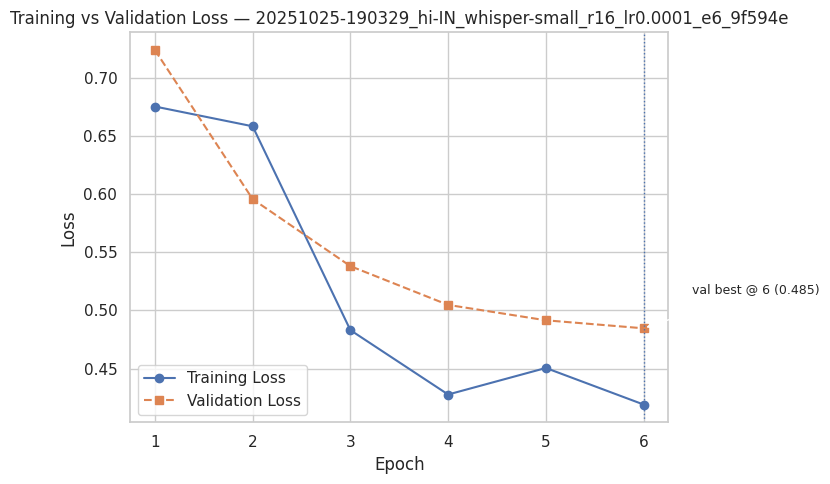

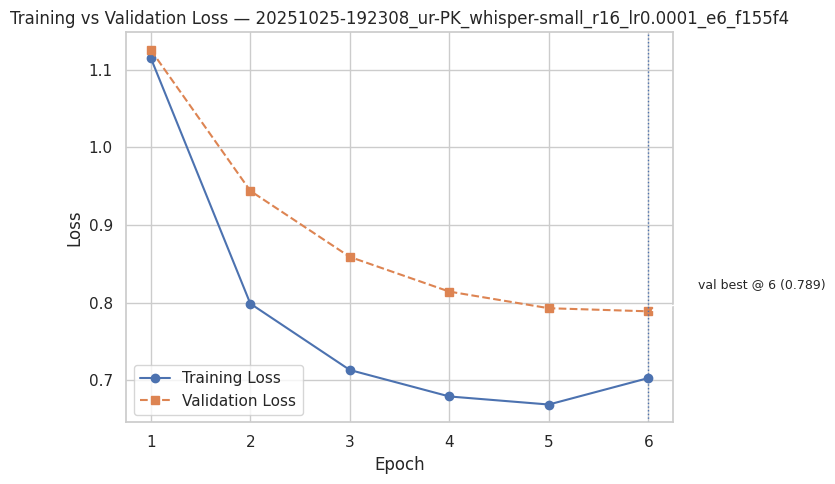

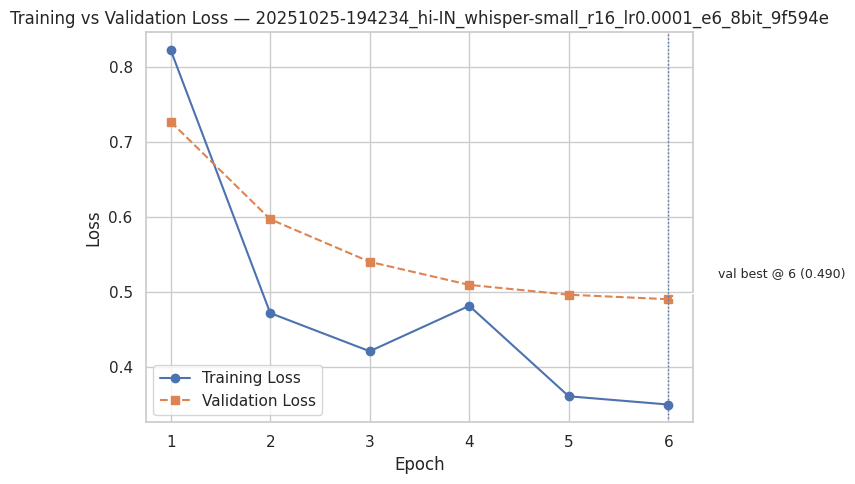

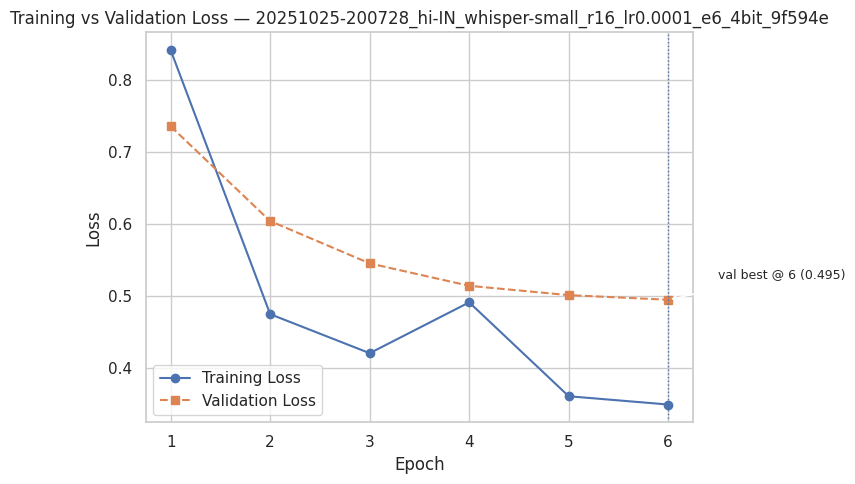

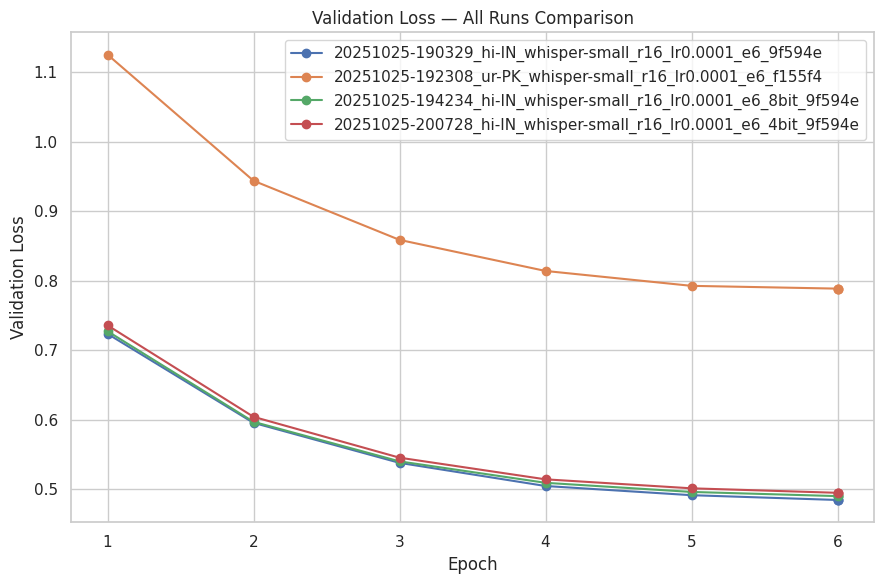

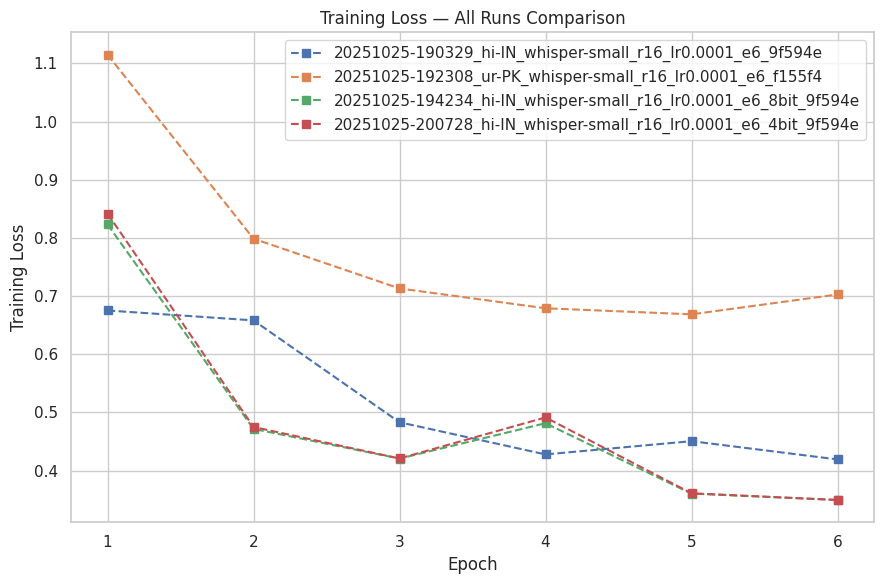

In [ ]:

# ==== Helper to mark best val point ====
def annotate_best(ax, xs, ys, label_prefix=""):
    # Ensure ys is not empty and contains valid numbers
    valid_ys = [y for y in ys if pd.notna(y)]
    if not valid_ys:
        return

    ymin = min(valid_ys)
    # Find the index in the original list
    try:
        idx = ys.index(ymin)
    except ValueError:
         # Handle cases where ymin is in valid_ys but not directly in ys
         closest_val = min(ys, key=lambda y: abs(y - ymin) if pd.notna(y) else float('inf'))
         idx = ys.index(closest_val)


    xbest = xs[idx]
    ax.axvline(xbest, linestyle=":", linewidth=1)
    ax.annotate(f"{label_prefix}best @ {xbest} ({ymin:.3f})",
                xy=(xbest, ymin),
                xytext=(xbest + 0.5, ymin + 0.03),
                arrowprops=dict(arrowstyle="->"),
                fontsize=9)


# ==== 1) Plot Training vs Validation for each run (separate PNGs) ====
for run_name, run_data in df.groupby("run"):
    plt.figure(figsize=(8,5))

    # Training loss
    plt.plot(run_data["epoch"], run_data["training_loss"], marker="o", label="Training Loss")

    # Validation loss
    # Filter out None values before plotting
    valid_eval_data = run_data.dropna(subset=['validation_loss'])
    if not valid_eval_data.empty:
        plt.plot(valid_eval_data["epoch"], valid_eval_data["validation_loss"], marker="s", linestyle="--", label="Validation Loss")

        # Mark best validation epoch
        annotate_best(plt.gca(), valid_eval_data["epoch"].tolist(), valid_eval_data["validation_loss"].tolist(), label_prefix="val ")

    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"Training vs Validation Loss — {run_name}")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

# ==== 2) Comparison plot: Validation loss across all runs ====
plt.figure(figsize=(9,6))
for run_name, run_data in df.groupby("run"):
    valid_eval_data = run_data.dropna(subset=['validation_loss'])
    if not valid_eval_data.empty:
        plt.plot(valid_eval_data["epoch"], valid_eval_data["validation_loss"], marker="o", linestyle="-", label=run_name)
        # Mark each run's best
        ymin = min(valid_eval_data["validation_loss"])
        xbest = valid_eval_data[valid_eval_data["validation_loss"] == ymin]["epoch"].iloc[0]
        plt.scatter([xbest], [ymin], s=40)


plt.xlabel("Epoch"); plt.ylabel("Validation Loss")
plt.title("Validation Loss — All Runs Comparison")
plt.legend()
plt.grid(True); plt.tight_layout()
plt.show()

# ==== 3) Comparison plot: Training loss across all runs ====
plt.figure(figsize=(9,6))
for run_name, run_data in df.groupby("run"):
     plt.plot(run_data["epoch"], run_data["training_loss"], marker="s", linestyle="--", label=run_name)

plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.title("Training Loss — All Runs Comparison")
plt.legend()
plt.grid(True); plt.tight_layout()
plt.show()

# Evaluation After FineTuning

In [25]:
# --- Reload adapter + processor (optionally in 4/8-bit for fast eval) ---
def load_lora_for_eval(run_dir, fp16=True, quant=None, device=None):
    run_dir = Path(run_dir)
    meta = json.loads((run_dir / "meta.json").read_text())
    base_id = meta["base_model_id"]

    bnb_args = {}
    if quant in (4, 8):
        from transformers import BitsAndBytesConfig
        bnb_args = {
            "quantization_config": BitsAndBytesConfig(
                load_in_4bit=(quant==4),
                load_in_8bit=(quant==8),
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16 if fp16 else torch.float32,
            )
        }

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    base = AutoModelForSpeechSeq2Seq.from_pretrained(
        base_id,
        torch_dtype=torch.float16 if fp16 else torch.float32,
        **bnb_args
    ).to(device)

    # Load the best model from the checkpoints directory
    checkpoint_dir = run_dir / "checkpoints"
    model = PeftModel.from_pretrained(base, checkpoint_dir)
    proc  = AutoProcessor.from_pretrained(checkpoint_dir)
    model.eval()
    return model, proc, meta

Load the registry and evaluate runs

In [ ]:
# --- Collect WER/CER for saved runs and write runs/results.csv ---

REG_PATH   = Path("/content/drive/MyDrive/ASR_runs/registry.csv")
RESULTS_CSV = Path("/content/drive/MyDrive/ASR_runs/results.csv")

def _get_langspec(lang_code):
    return next(l for l in LANGS if l.code == lang_code)

def _eval_baseline(base_model_id, lang_code, cache):
    key = (base_model_id, lang_code)
    if key in cache:
        return cache[key]
    lang = _get_langspec(lang_code)
    res = eval_language(base_model_id, lang)
    cache[key] = res
    return res

def _eval_finetuned(run_dir, lang_code):
    lang = _get_langspec(lang_code)
    # run_dir is a folder path; eval_language can load from dir (adapters + processor)
    return eval_language(str(run_dir), lang)

def collect_results(recompute=False, limit=None, sleep_between=0.0):
    assert REG_PATH.exists(), f"Registry not found at {REG_PATH}"
    # Add on_bad_lines='skip' to handle inconsistent rows
    reg = pd.read_csv(REG_PATH, on_bad_lines='skip')
    if limit is not None:
        reg = reg.head(int(limit))

    #  skip re-evaluating if we already have results.csv
    existing = pd.read_csv(RESULTS_CSV) if RESULTS_CSV.exists() and not recompute else pd.DataFrame()

    rows = []
    baseline_cache = {}

    for _, r in reg.iterrows():
        run_dir = r["run_dir"]
        base_id = r["base_model_id"]
        lang_code = r["lang_code"]

        # if results already exist and not recomputing, carry forward
        if not recompute and not existing.empty:
            match = existing[(existing.run_dir == run_dir)]
            if len(match) == 1:
                rows.append(match.iloc[0].to_dict())
                continue

        base_res = _eval_baseline(base_id, lang_code, baseline_cache)
        ft_res   = _eval_finetuned(run_dir, lang_code)

        # Expect eval_language to return dict-like with at least 'WER' and 'CER'
        row = {
            "run_dir": run_dir,
            "base_model_id": base_id,
            "lang_code": lang_code,
            "wer_base": base_res.get("WER", base_res.get("wer", None)),
            "cer_base": base_res.get("CER", base_res.get("cer", None)),
            "wer_ft":   ft_res.get("WER", ft_res.get("wer", None)),
            "cer_ft":   ft_res.get("CER", ft_res.get("cer", None)),
        }
        # deltas (negative is better)
        if row["wer_base"] is not None and row["wer_ft"] is not None:
            row["wer_delta"] = row["wer_ft"] - row["wer_base"]
        if row["cer_base"] is not None and row["cer_ft"] is not None:
            row["cer_delta"] = row["cer_ft"] - row["cer_base"]

        # merge meta from registry (LoRA/quant etc.)
        for k in ["r","alpha","dropout","epochs","lr","fp16","q4","q8","timestamp","notes"]:
            row[k] = r.get(k, None)

        rows.append(row)
        if sleep_between:
            time.sleep(sleep_between)

    df = pd.DataFrame(rows)
    RESULTS_CSV.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(RESULTS_CSV, index=False)
    print(f"Wrote {RESULTS_CSV} with {len(df)} rows.")
    return df

# Run collection
results_df = collect_results(recompute=True, limit=None)
results_df

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Wrote /content/drive/MyDrive/ASR_runs/results.csv with 4 rows.


,run_dir,base_model_id,lang_code,wer_base,cer_base,wer_ft,cer_ft,wer_delta,cer_delta,r,alpha,dropout,epochs,lr,fp16,q4,q8,timestamp,notes
0,/content/drive/MyDrive/ASR_runs/20251025-19032...,openai/whisper-small,hi-IN,0.499421,0.252764,0.301814,0.128225,-0.197607,-0.124539,16,32,0.05,6,0.0001,True,False,False,2025-10-25 19:22:42,grid_v1
1,/content/drive/MyDrive/ASR_runs/20251025-19230...,openai/whisper-small,ur-PK,0.367534,0.139269,0.410040,0.156947,0.042506,0.017679,16,32,0.05,6,0.0001,True,False,False,2025-10-25 19:42:11,grid_v1
2,/content/drive/MyDrive/ASR_runs/20251025-19423...,openai/whisper-small,hi-IN,0.499421,0.252764,0.304130,0.130682,-0.195291,-0.122082,16,32,0.05,6,0.0001,True,False,True,2025-10-25 20:07:07,grid_v1
3,/content/drive/MyDrive/ASR_runs/20251025-20072...,openai/whisper-small,hi-IN,0.499421,0.252764,0.311077,0.130682,-0.188344,-0.122082,16,32,0.05,6,0.0001,True,True,False,2025-10-25 20:28:02,grid_v1


Plot helpers (WER/CER bars + delta chart

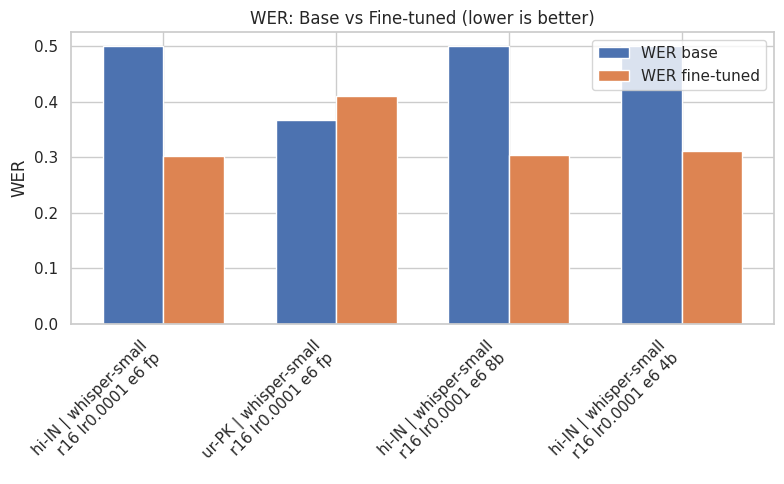

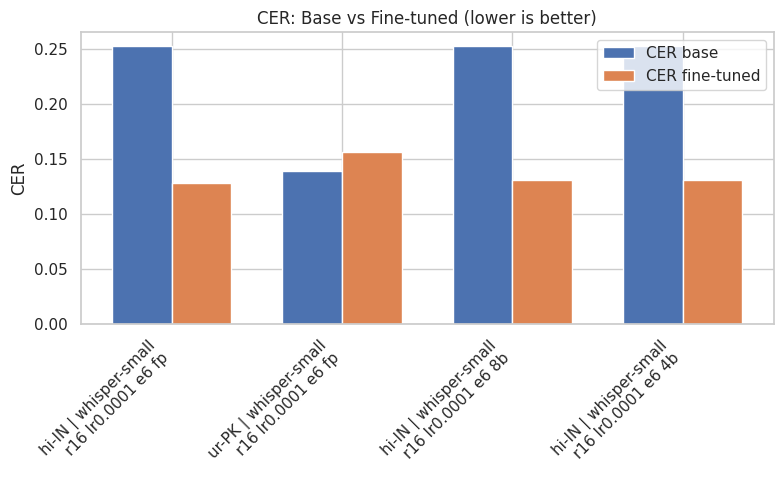

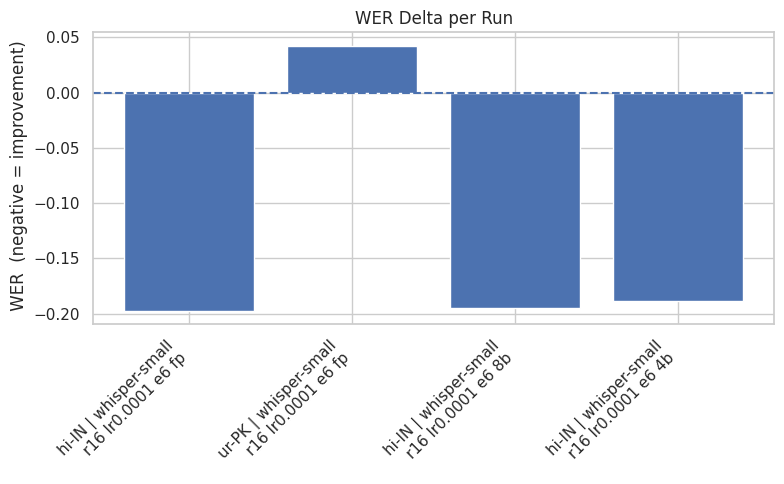

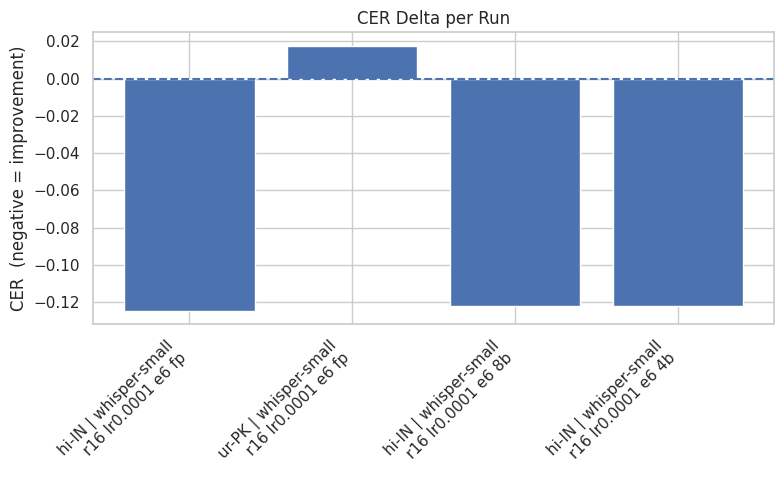

In [ ]:
# --- Plotting helpers for WER/CER and deltas ---

def _load_results():
    assert RESULTS_CSV.exists(), "No results.csv yet. Run collect_results() first."
    df = pd.read_csv(RESULTS_CSV)
    # Add a compact label per run for x-axis
    def short_label(row):
        q = "4b" if bool(row.get("q4", False)) else ("8b" if bool(row.get("q8", False)) else "fp")
        return f"{row['lang_code']} | {Path(row['base_model_id']).name}\n r{row.get('r', '')} lr{row.get('lr', '')} e{row.get('epochs', '')} {q}"
    df["run_label"] = df.apply(short_label, axis=1)
    return df

def plot_wer_cer_bars(df, max_runs=20):
    df2 = df.copy().head(max_runs)
    x = range(len(df2))
    width = 0.35

    plt.figure(figsize=(max(8, len(df2)*0.9), 5))
    plt.bar([i - width/2 for i in x], df2["wer_base"], width, label="WER base")
    plt.bar([i + width/2 for i in x], df2["wer_ft"],   width, label="WER fine-tuned")
    plt.xticks(list(x), df2["run_label"], rotation=45, ha="right")
    plt.ylabel("WER")
    plt.title("WER: Base vs Fine-tuned (lower is better)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(max(8, len(df2)*0.9), 5))
    plt.bar([i - width/2 for i in x], df2["cer_base"], width, label="CER base")
    plt.bar([i + width/2 for i in x], df2["cer_ft"],   width, label="CER fine-tuned")
    plt.xticks(list(x), df2["run_label"], rotation=45, ha="right")
    plt.ylabel("CER")
    plt.title("CER: Base vs Fine-tuned (lower is better)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_deltas(df, max_runs=30):
    df3 = df.copy().head(max_runs)
    x = range(len(df3))

    plt.figure(figsize=(max(8, len(df3)*0.9), 5))
    plt.axhline(0, linestyle="--")
    plt.bar(x, df3["wer_delta"], label="WER  (FT - Base)")
    plt.xticks(list(x), df3["run_label"], rotation=45, ha="right")
    plt.ylabel(" WER  (negative = improvement)")
    plt.title("WER Delta per Run")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(max(8, len(df3)*0.9), 5))
    plt.axhline(0, linestyle="--")
    plt.bar(x, df3["cer_delta"], label="CER  (FT - Base)")
    plt.xticks(list(x), df3["run_label"], rotation=45, ha="right")
    plt.ylabel("CER  (negative = improvement)")
    plt.title("CER Delta per Run")
    plt.tight_layout()
    plt.show()

# Load & plot
_df = _load_results()
plot_wer_cer_bars(_df)
plot_deltas(_df)


Filter & plot by language or model

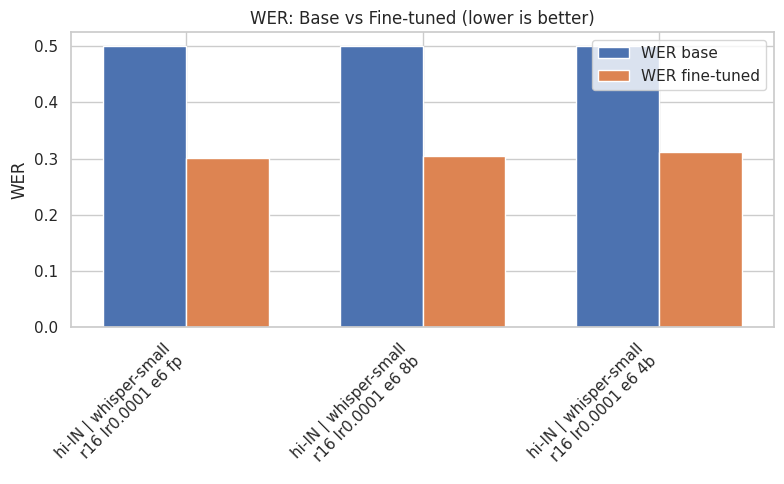

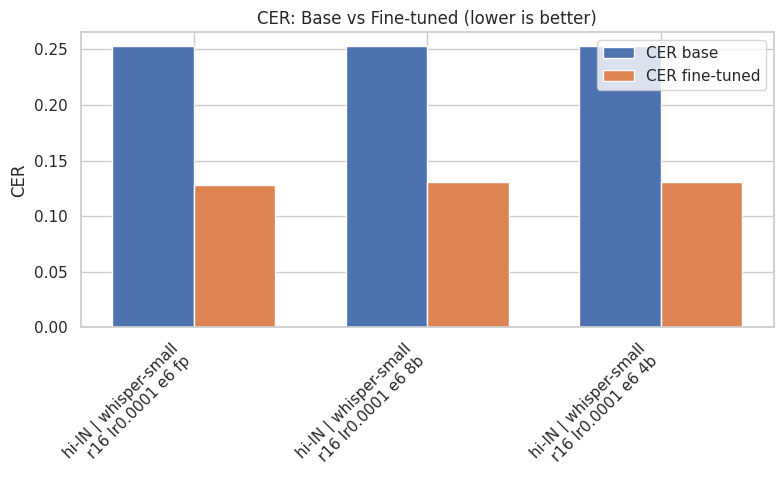

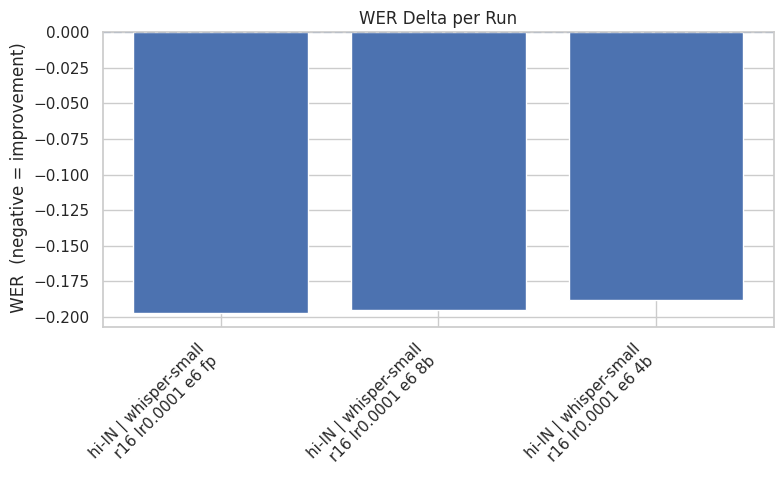

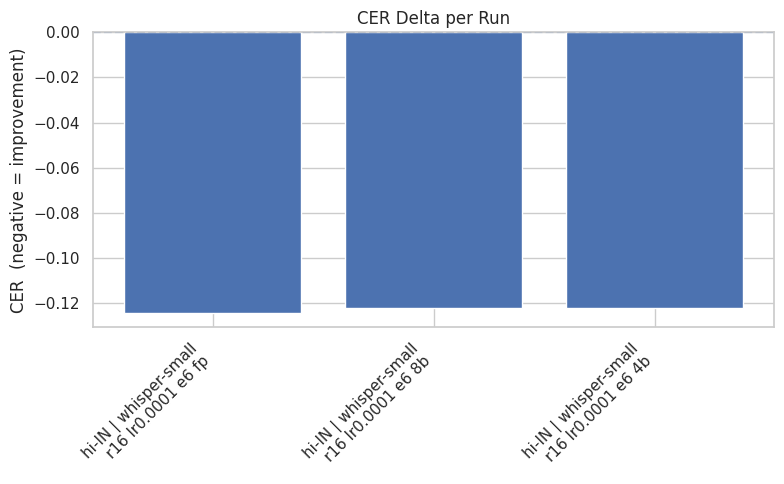

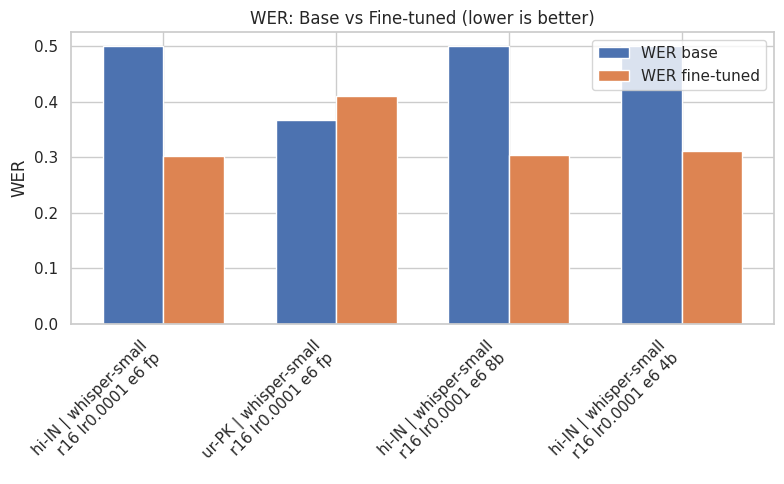

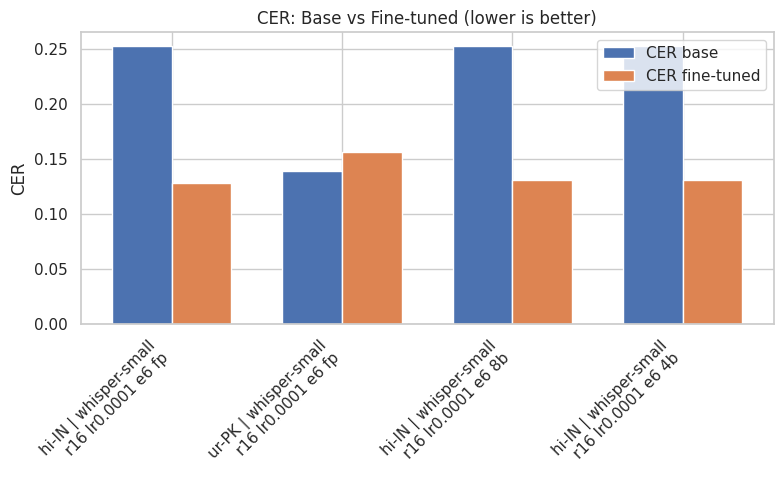

In [ ]:
# Example: only Hindi runs
hindi = _df[_df["lang_code"] == "hi-IN"].copy()
plot_wer_cer_bars(hindi)
plot_deltas(hindi)

# Example: only whisper-small vs only whisper-base
small = _df[_df["base_model_id"].str.contains("whisper-small")]
plot_wer_cer_bars(small)




---

# More Fine Tuning Experiments for Urdu

In [ ]:
REG_PATH = Path("/content/drive/MyDrive/ASR_runs/registry.csv")

if REG_PATH.exists():
    # Add on_bad_lines='skip' to handle inconsistent rows
    registry_df = pd.read_csv(REG_PATH, on_bad_lines='skip')
    saved_runs = registry_df["run_dir"].tolist()
    print(f"Initialized saved_runs with {len(saved_runs)} runs from registry.csv")
else:
    saved_runs = []
    print(f"Registry not found at {REG_PATH}. Initializing saved_runs as empty.")

Initialized saved_runs with 8 runs from registry.csv


# Short FT with lower LR

Earlier Urdu run used r=16, lr=1e-4, 6 epochs without quantization, and it shows training loss ↓ but val loss plateauing at ~0.79 (and slightly up at epoch 6). That’s a mild overfit signal.
Let's try

*   Cut epochs to 3–4 i.e  early stopping on val loss.
*    Drop LR to  3e-5 as data is small




In [ ]:
experiment_grid = [
    # (base_model_id, lang_code, lr, lora_r, epochs, quant, train_hours, eval_hours)
    ("openai/whisper-small",  "ur-PK", 3e-5, 16, 6, None, 2.0, 0.01),
]

for base_id, lang_code, lr, r, epochs, quant, train_hours, eval_hours in experiment_grid:
    # prepare a per-run cfg
    cfg_run = replace(cfg,
        base_model_id=base_id,
        lr=lr, lora_r=r, num_epochs=epochs,
        load_in_4bit=(quant==4), load_in_8bit=(quant==8),
        train_hours=train_hours, # Set train_hours
        eval_hours=eval_hours,   # Set eval_hours
    )
    lang = next(l for l in LANGS if l.code == lang_code)
    out_dir = train_one_experiment(cfg_run, lang, notes="grid_urdu_v2")
    saved_runs.append(str(out_dir))

trainable params: 6,488,064 || all params: 248,222,976 || trainable%: 2.6138
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Training 20251026-093856_ur-PK_whisper-small_r16_lr3e-05_e6_e91a54 ...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.670900,1.633987
2,1.123500,1.297340
3,1.084900,1.122503
4,0.991400,1.070829
5,1.093300,1.051282
6,1.230900,1.044214


Saved training history to: /content/drive/MyDrive/ASR_runs/20251026-093856_ur-PK_whisper-small_r16_lr3e-05_e6_e91a54/training_history.json
Saved: /content/drive/MyDrive/ASR_runs/20251026-093856_ur-PK_whisper-small_r16_lr3e-05_e6_e91a54




---
# Fine Tuning Experimenat with increased training Data for Hindi


In [ ]:
experiment_grid = [
    # (base_model_id, lang_code, lr, lora_r, epochs, quant, train_hours, eval_hours)
    ("openai/whisper-small", "hi-IN", 1e-4, 16, 6, 4, 3.0, 0.01),
]

for base_id, lang_code, lr, r, epochs, quant, train_hours, eval_hours in experiment_grid:
    # prepare a per-run cfg
    cfg_run = replace(cfg,
        base_model_id=base_id,
        lr=lr, lora_r=r, num_epochs=epochs,
        load_in_4bit=(quant==4), load_in_8bit=(quant==8),
        train_hours=train_hours, # Set train_hours
        eval_hours=eval_hours,   # Set eval_hours
    )
    lang = next(l for l in LANGS if l.code == lang_code)
    out_dir = train_one_experiment(cfg_run, lang, notes="grid_hindi_v2")
    saved_runs.append(str(out_dir))

Using quantization: 4-bit
trainable params: 6,488,064 || all params: 248,222,976 || trainable%: 2.6138


hi_in/train/0000.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


hi_in/validation/0000.parquet:   0%|          | 0.00/162M [00:00<?, ?B/s]

Generating validation split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Training 20251026-100628_hi-IN_whisper-small_r16_lr0.0001_e6_4bit_3df581 ...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.646100,0.661905
2,0.532900,0.540380
3,0.379900,0.484068
4,0.298600,0.447818
5,0.269900,0.431742
6,0.280200,0.426936


Saved training history to: /content/drive/MyDrive/ASR_runs/20251026-100628_hi-IN_whisper-small_r16_lr0.0001_e6_4bit_3df581/training_history.json
Saved: /content/drive/MyDrive/ASR_runs/20251026-100628_hi-IN_whisper-small_r16_lr0.0001_e6_4bit_3df581


More Training Data

In [ ]:
experiment_grid = [
    # (base_model_id, lang_code, lr, lora_r, epochs, quant, train_hours, eval_hours)
    ("openai/whisper-small", "hi-IN", 1e-4, 16, 10, 4, 5.0, 0.01),
]

for base_id, lang_code, lr, r, epochs, quant, train_hours, eval_hours in experiment_grid:
    # prepare a per-run cfg
    cfg_run = replace(cfg,
        base_model_id=base_id,
        lr=lr, lora_r=r, num_epochs=epochs,
        load_in_4bit=(quant==4), load_in_8bit=(quant==8),
        train_hours=train_hours, # Set train_hours
        eval_hours=eval_hours,   # Set eval_hours
    )
    lang = next(l for l in LANGS if l.code == lang_code)
    out_dir = train_one_experiment(cfg_run, lang, notes="grid_hindi_largerData")
    saved_runs.append(str(out_dir))

Using quantization: 4-bit


model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

trainable params: 6,488,064 || all params: 248,222,976 || trainable%: 2.6138


hi_in/train/0000.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


hi_in/validation/0000.parquet:   0%|          | 0.00/162M [00:00<?, ?B/s]

Generating validation split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Training 20251026-125303_hi-IN_whisper-small_r16_lr0.0001_e10_4bit_94ce1e ...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.731300,0.660946
2,0.443600,0.528270
3,0.300500,0.459440
4,0.273600,0.422850
5,0.222900,0.393101
6,0.186400,0.388447
7,0.160600,0.393883
8,0.136200,0.396848
9,0.085700,0.400544
10,0.122100,0.402477


Saved training history to: /content/drive/MyDrive/ASR_runs/20251026-125303_hi-IN_whisper-small_r16_lr0.0001_e10_4bit_94ce1e/training_history.json
Saved: /content/drive/MyDrive/ASR_runs/20251026-125303_hi-IN_whisper-small_r16_lr0.0001_e10_4bit_94ce1e


NameError: name 'saved_runs' is not defined

Evaluation

In [ ]:
rows = []
for run_dir_str in saved_runs:
    run_dir = Path(run_dir_str)
    history_path = run_dir / "training_history.json"
    if history_path.exists():
        with open(history_path, "r") as f:
            log_history = json.load(f)

        run_name = run_dir.name # Run directory name as the run identifier
        # Filter for logs with 'loss' and where epoch is a whole number
        train_logs = [log for log in log_history if 'loss' in log and 'epoch' in log and log['epoch'] == int(log['epoch'])]
        eval_logs = [log for log in log_history if 'eval_loss' in log]
        # Create a dictionary for easier lookup of eval loss by epoch
        eval_loss_dict = {int(log['epoch']): log['eval_loss'] for log in eval_logs}

        for train_log in train_logs:
            epoch = int(train_log['epoch'])
            training_loss = train_log['loss']
            validation_loss = eval_loss_dict.get(epoch) # Get corresponding validation loss
            rows.append({"run": run_name, "epoch": epoch, "training_loss": training_loss, "validation_loss": validation_loss})

# Create DataFrame
df = pd.DataFrame(rows)
# ====export all to CSV ====
# Define the target directory
target_directory = "/content/drive/MyDrive/ASR_runs"
os.makedirs(target_directory, exist_ok=True) # Ensure the directory exists

csv_filename = "all_runs_losses.csv"
full_csv_path = os.path.join(target_directory, csv_filename)

df.to_csv(full_csv_path, index=False)
print(f"Saved CSV -> {full_csv_path}")
df

Saved CSV -> /content/drive/MyDrive/ASR_runs/all_runs_losses.csv


,run,epoch,training_loss,validation_loss
0,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,1,0.6752,0.723688
1,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,2,0.6582,0.595653
2,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,3,0.4831,0.538076
3,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,4,0.4278,0.504775
4,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,5,0.4506,0.491555
5,20251025-190329_hi-IN_whisper-small_r16_lr0.00...,6,0.4192,0.484670
6,20251025-192308_ur-PK_whisper-small_r16_lr0.00...,1,1.1150,1.125318
7,20251025-192308_ur-PK_whisper-small_r16_lr0.00...,2,0.7986,0.943889
8,20251025-192308_ur-PK_whisper-small_r16_lr0.00...,3,0.7131,0.858815
9,20251025-192308_ur-PK_whisper-small_r16_lr0.00...,4,0.6790,0.814109


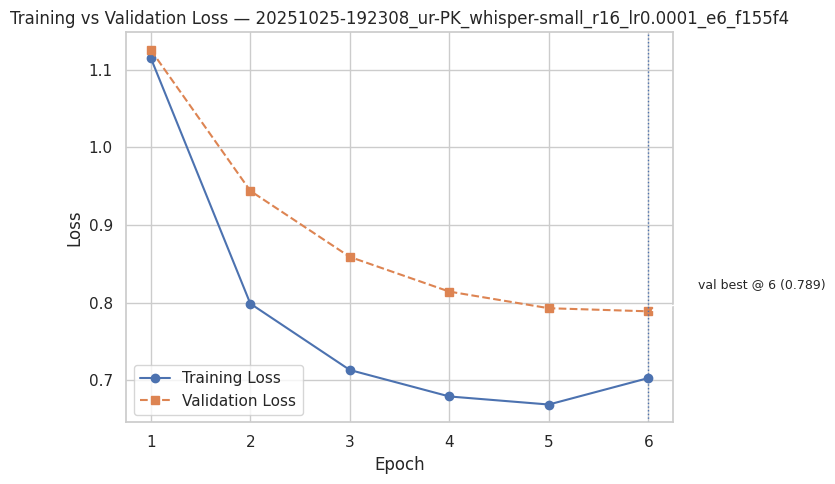

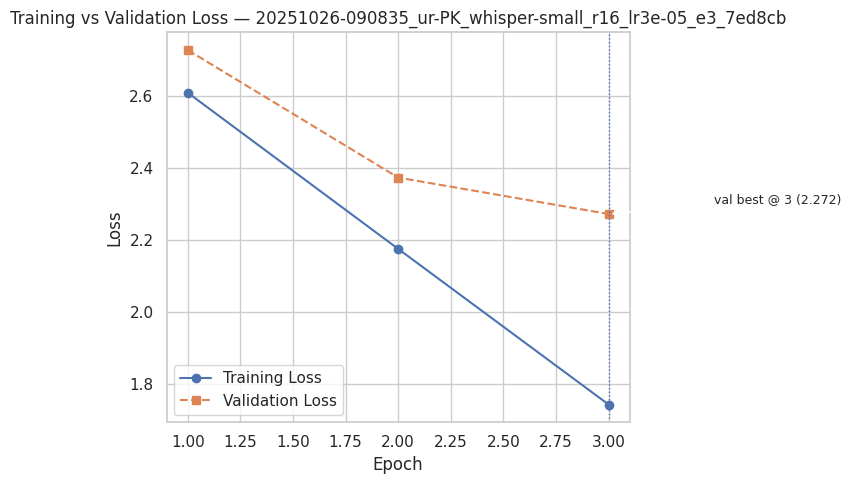

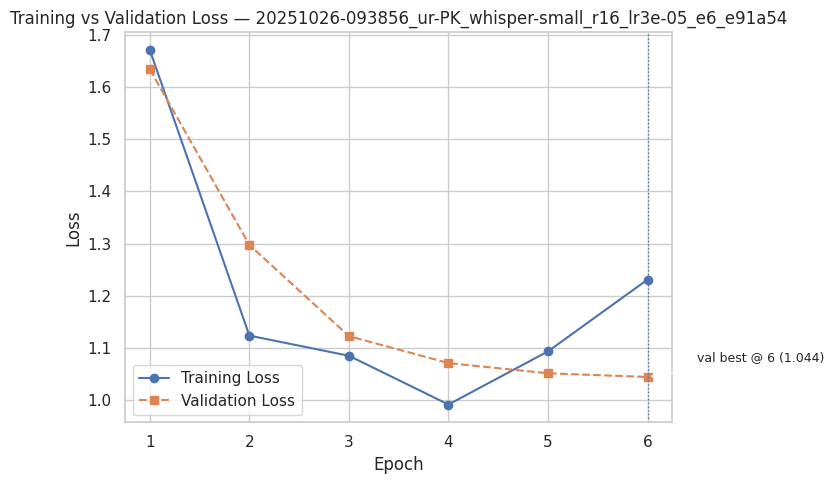

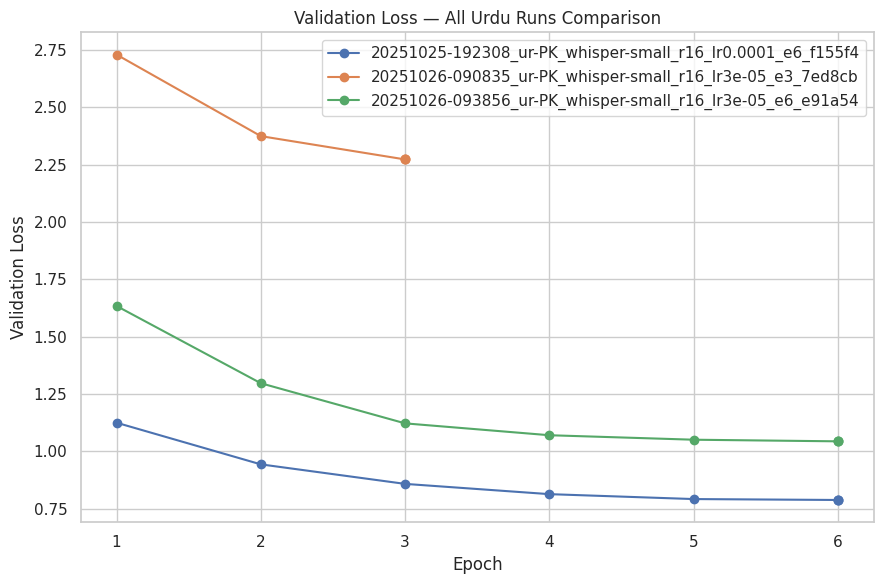

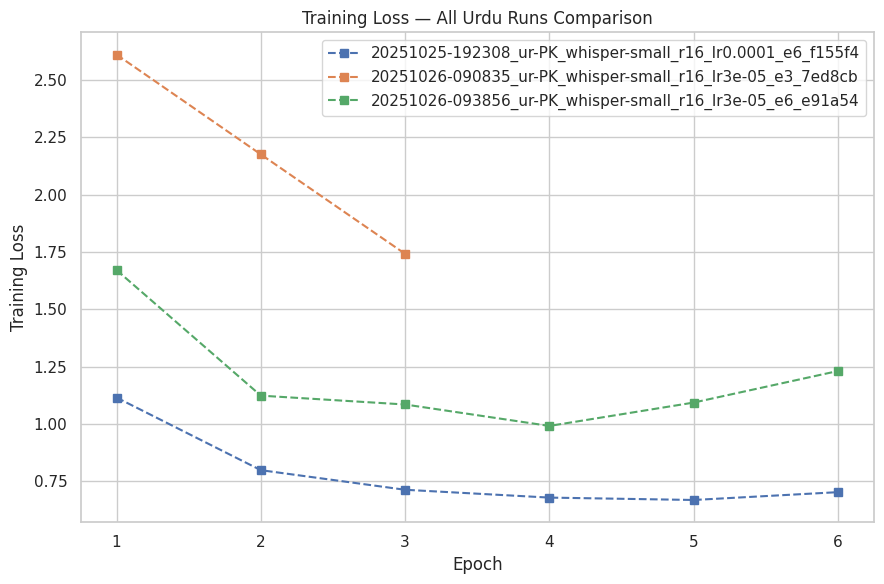

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for only Urdu runs
urdu_df = df[df['run'].str.contains('ur-PK')].copy()

# Set plot style
sns.set_theme(style="whitegrid")

# Plot Training vs Validation for each Urdu run (separate PNGs)
for run_name, run_data in urdu_df.groupby("run"):
    plt.figure(figsize=(8,5))

    # Training loss
    plt.plot(run_data["epoch"], run_data["training_loss"], marker="o", label="Training Loss")

    # Validation loss
    # Filter out None values before plotting
    valid_eval_data = run_data.dropna(subset=['validation_loss'])
    if not valid_eval_data.empty:
        plt.plot(valid_eval_data["epoch"], valid_eval_data["validation_loss"], marker="s", linestyle="--", label="Validation Loss")

        # Mark best validation epoch
        annotate_best(plt.gca(), valid_eval_data["epoch"].tolist(), valid_eval_data["validation_loss"].tolist(), label_prefix="val ")

    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"Training vs Validation Loss — {run_name}")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

# Comparison plot: Validation loss across all Urdu runs
plt.figure(figsize=(9,6))
for run_name, run_data in urdu_df.groupby("run"):
    valid_eval_data = run_data.dropna(subset=['validation_loss'])
    if not valid_eval_data.empty:
        plt.plot(valid_eval_data["epoch"], valid_eval_data["validation_loss"], marker="o", linestyle="-", label=run_name)
        # Mark each run's best
        ymin = min(valid_eval_data["validation_loss"])
        xbest = valid_eval_data[valid_eval_data["validation_loss"] == ymin]["epoch"].iloc[0]
        plt.scatter([xbest], [ymin], s=40)


plt.xlabel("Epoch"); plt.ylabel("Validation Loss")
plt.title("Validation Loss — All Urdu Runs Comparison")
plt.legend()
plt.grid(True); plt.tight_layout()
plt.show()

# Comparison plot: Training loss across all Urdu runs
plt.figure(figsize=(9,6))
for run_name, run_data in urdu_df.groupby("run"):
     plt.plot(run_data["epoch"], run_data["training_loss"], marker="s", linestyle="--", label=run_name)

plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.title("Training Loss — All Urdu Runs Comparison")
plt.legend()
plt.grid(True); plt.tight_layout()
plt.show()

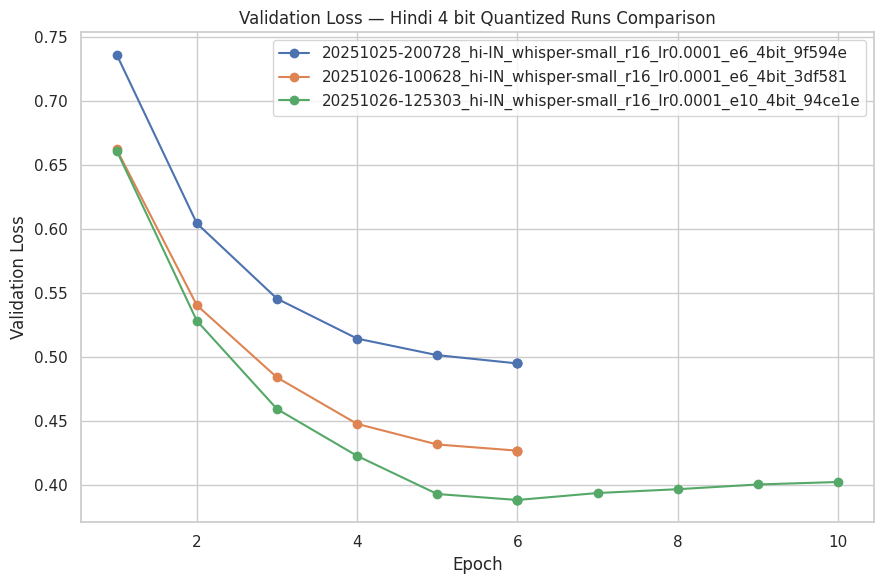

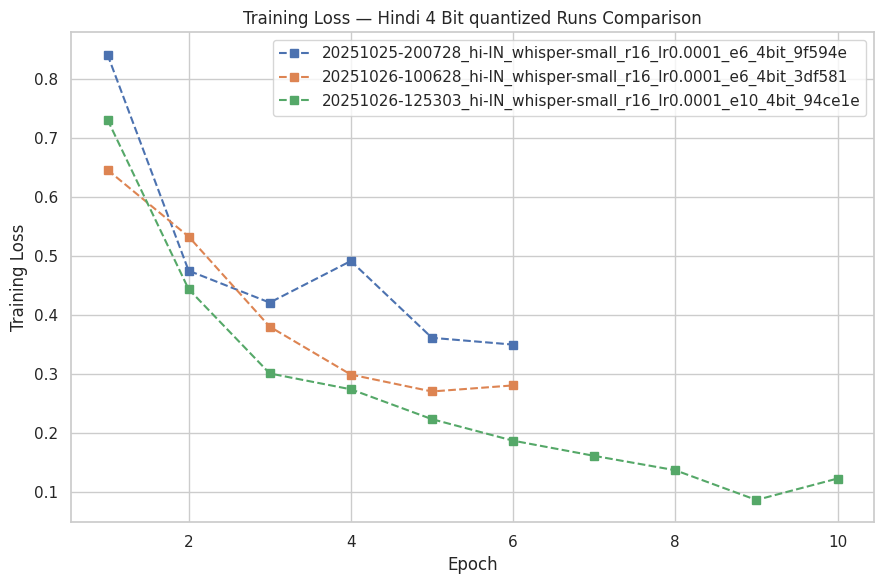

In [ ]:
# Filter for only Hindi 4 bit runs
hindi_4bit_df = df[
    (df['run'].str.contains('hi-IN')) &
    (df['run'].str.contains('4bit'))
].copy()

# Comparison plot: Validation loss across hindi 4 bit quantized runs ====
plt.figure(figsize=(9,6))
for run_name, run_data in hindi_4bit_df.groupby("run"):
    valid_eval_data = run_data.dropna(subset=['validation_loss'])
    if not valid_eval_data.empty:
        plt.plot(valid_eval_data["epoch"], valid_eval_data["validation_loss"], marker="o", linestyle="-", label=run_name)
        # Mark each run's best
        ymin = min(valid_eval_data["validation_loss"])
        xbest = valid_eval_data[valid_eval_data["validation_loss"] == ymin]["epoch"].iloc[0]
        plt.scatter([xbest], [ymin], s=40)


plt.xlabel("Epoch"); plt.ylabel("Validation Loss")
plt.title("Validation Loss — Hindi 4 bit Quantized Runs Comparison")
plt.legend()
plt.grid(True); plt.tight_layout()
plt.show()

# Comparison plot: Training loss across hindi 4 bit quantized runs ====
plt.figure(figsize=(9,6))
for run_name, run_data in hindi_4bit_df.groupby("run"):
     plt.plot(run_data["epoch"], run_data["training_loss"], marker="s", linestyle="--", label=run_name)

plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.title("Training Loss — Hindi 4 Bit quantized Runs Comparison")
plt.legend()
plt.grid(True); plt.tight_layout()
plt.show()

In [ ]:
# Run collection
results_df = collect_results(recompute=False, limit=None)
results_df

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']


hi_in/test/0000.parquet:   0%|          | 0.00/306M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Wrote /content/drive/MyDrive/ASR_runs/results.csv with 8 rows.


,run_dir,base_model_id,lang_code,wer_base,cer_base,wer_ft,cer_ft,wer_delta,cer_delta,r,alpha,dropout,epochs,lr,fp16,q4,q8,timestamp,notes
0,/content/drive/MyDrive/ASR_runs/20251025-19032...,openai/whisper-small,hi-IN,0.499421,0.252764,0.301814,0.128225,-0.197607,-0.124539,16,32,0.05,6,0.00010,True,False,False,2025-10-25 19:22:42,grid_v1
1,/content/drive/MyDrive/ASR_runs/20251025-19230...,openai/whisper-small,ur-PK,0.367534,0.139269,0.410040,0.156947,0.042506,0.017679,16,32,0.05,6,0.00010,True,False,False,2025-10-25 19:42:11,grid_v1
2,/content/drive/MyDrive/ASR_runs/20251025-19423...,openai/whisper-small,hi-IN,0.499421,0.252764,0.304130,0.130682,-0.195291,-0.122082,16,32,0.05,6,0.00010,True,False,True,2025-10-25 20:07:07,grid_v1
3,/content/drive/MyDrive/ASR_runs/20251025-20072...,openai/whisper-small,hi-IN,0.499421,0.252764,0.311077,0.130682,-0.188344,-0.122082,16,32,0.05,6,0.00010,True,True,False,2025-10-25 20:28:02,grid_v1
4,/content/drive/MyDrive/ASR_runs/20251026-09083...,openai/whisper-small,ur-PK,0.367534,0.139269,0.377061,0.142069,0.009527,0.002800,16,32,0.05,3,0.00003,True,False,False,2025-10-26 09:11:03,grid_urdu_v2
5,/content/drive/MyDrive/ASR_runs/20251026-09385...,openai/whisper-small,ur-PK,0.367534,0.139269,0.421766,0.164947,0.054232,0.025678,16,32,0.05,6,0.00003,True,False,False,2025-10-26 09:57:46,grid_urdu_v2
6,/content/drive/MyDrive/ASR_runs/20251026-10062...,openai/whisper-small,hi-IN,0.499421,0.252764,0.293323,0.123757,-0.206098,-0.129007,16,32,0.05,6,0.00010,True,True,False,2025-10-26 10:32:57,grid_urdu_v2
7,/content/drive/MyDrive/ASR_runs/20251026-12530...,openai/whisper-small,hi-IN,0.499421,0.252764,0.294481,0.111918,-0.204940,-0.140847,16,32,0.05,10,0.00010,True,True,False,2025-10-26 13:37:04,grid_hindi_largerData




---


Prepare Urdu text for evaluation by applying several normalization steps. It uses NFKC normalization to handle character variations, removes diacritics and other control characters, unifies different forms of similar-looking letters (like Yeh and Alef Maksura), removes general punctuation, and replaces multiple spaces with single spaces. This helps ensure consistent text representation for accurate metric calculation.



In [26]:
import unicodedata
import re

# === Data Normalization & Metrics (Stricter Urdu Normalization) ===

def normalize_urdu_strict(text: str) -> str:
    t = (text or "").strip()
    # Apply NFKC normalization (handles ligatures, etc.)
    t = unicodedata.normalize("NFKC", t)

    # Specific Urdu/Arabic normalization (remove diacritics, Tatweel, bidi control chars)
    t = re.sub(r"[\u064b-\u0652\u0670\u06d6-\u06dc\u06df-\u06e4\u06e7-\u06e8\u06ea-\u06ed]", "", t) # Remove diacritics
    t = re.sub(r"\u0640", "", t) # Remove Tatweel
    t = re.sub(r"[\u200b-\u200f\u2028-\u202e\u2066-\u206f]", "", t) # Remove Bidi control characters

    # Unify Yeh (ی) and Alef Maksura (ى) - map to Yeh
    t = re.sub(r"\u0649", "\u064a", t)
    # Unify Kaf (ک) and Keheh (ۀ) - map to Kaf
    t = re.sub(r"\u06a9", "\u06a9", t) # Already Kaf, just to be explicit

    # Remove punctuation (update regex to include common Arabic/Urdu punctuation if needed, keeping current for now)
    t = re.sub(r"[^\w\s]", "", t)

    # Replace multiple spaces with a single space
    t = re.sub(r"\s+", " ", t)
    return t

def compute_metrics_strict_urdu(refs, hyps):
    refs_n = [normalize_urdu_strict(r) for r in refs]
    hyps_n = [normalize_urdu_strict(h) for h in hyps]
    # Use jiwer for WER/CER
    return dict(WER=wer(refs_n, hyps_n), CER=cer(refs_n, hyps_n))

In [32]:
# === UpdatednEvaluation Driver with Conditional Strict Urdu Metrics ===
def eval_language(model_id: str, lang) -> dict:
    test = build_split(lang, "test", SAMPLE_HOURS["test"])
    if len(test) == 0:
        return dict(model=model_id, lang=lang.code, family=lang.family, level=lang.resource_level, WER=None, CER=None)
    refs, hyps = transcribe_batch(model_id, test, lang.code)

    # Use strict Urdu metrics for Urdu, otherwise use the default metrics
    if lang.code == "ur-PK":
        m = compute_metrics_strict_urdu(refs, hyps)
    else:
        m = compute_metrics(refs, hyps)

    return dict(model=model_id, lang=lang.code, family=lang.family, level=lang.resource_level, **m)

In [35]:

RESULTS_CSV_Urdu = Path("/content/drive/MyDrive/ASR_runs/results_urdu.csv")

def collect_results(recompute=False, limit=None, sleep_between=0.0):
    assert REG_PATH.exists(), f"Registry not found at {REG_PATH}"
    # Add on_bad_lines='skip' to handle inconsistent rows
    reg = pd.read_csv(REG_PATH, on_bad_lines='skip')
    reg = reg[reg["lang_code"] == "ur-PK"].copy()
    if limit is not None:
        reg = reg.head(int(limit))

    #  skip re-evaluating if we already have results_urdu.csv
    existing = pd.read_csv(RESULTS_CSV_Urdu) if RESULTS_CSV_Urdu.exists() and not recompute else pd.DataFrame()

    rows = []
    baseline_cache = {}

    for _, r in reg.iterrows():
        run_dir = r["run_dir"]
        base_id = r["base_model_id"]
        lang_code = r["lang_code"]

        # if results already exist and not recomputing, carry forward
        if not recompute and not existing.empty:
            match = existing[(existing.run_dir == run_dir)]
            if len(match) == 1:
                rows.append(match.iloc[0].to_dict())
                continue

        base_res = _eval_baseline(base_id, lang_code, baseline_cache)
        ft_res   = _eval_finetuned(run_dir, lang_code)

        # Expect eval_language to return dict-like with at least 'WER' and 'CER'
        row = {
            "run_dir": run_dir,
            "base_model_id": base_id,
            "lang_code": lang_code,
            "wer_base": base_res.get("WER", base_res.get("wer", None)),
            "cer_base": base_res.get("CER", base_res.get("cer", None)),
            "wer_ft":   ft_res.get("WER", ft_res.get("wer", None)),
            "cer_ft":   ft_res.get("CER", ft_res.get("cer", None)),
        }
        # deltas (negative is better)
        if row["wer_base"] is not None and row["wer_ft"] is not None:
            row["wer_delta"] = row["wer_ft"] - row["wer_base"]
        if row["cer_base"] is not None and row["cer_ft"] is not None:
            row["cer_delta"] = row["cer_ft"] - row["cer_base"]

        # merge meta from registry (LoRA/quant etc.)
        for k in ["r","alpha","dropout","epochs","lr","fp16","q4","q8","timestamp","notes"]:
            row[k] = r.get(k, None)

        rows.append(row)
        if sleep_between:
            time.sleep(sleep_between)

    df = pd.DataFrame(rows)
    RESULTS_CSV_Urdu.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(RESULTS_CSV_Urdu, index=False)
    print(f"Wrote {RESULTS_CSV_Urdu} with {len(df)} rows.")
    return df



In [36]:
# Run collection
results_df = collect_results(recompute=False, limit=2)
results_df

ur_pk/test/0000.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
dataset columns: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id']
Wrote /content/drive/MyDrive/ASR_runs/results_urdu.csv with 2 rows.


,run_dir,base_model_id,lang_code,wer_base,cer_base,wer_ft,cer_ft,wer_delta,cer_delta,r,alpha,dropout,epochs,lr,fp16,q4,q8,timestamp,notes
0,/content/drive/MyDrive/ASR_runs/20251025-19230...,openai/whisper-small,ur-PK,0.367534,0.139269,0.410040,0.156947,0.042506,0.017679,16,32,0.05,6,0.00010,True,False,False,2025-10-25 19:42:11,grid_v1
1,/content/drive/MyDrive/ASR_runs/20251026-09083...,openai/whisper-small,ur-PK,0.367534,0.139269,0.377061,0.142069,0.009527,0.002800,16,32,0.05,3,0.00003,True,False,False,2025-10-26 09:11:03,grid_urdu_v2
